## Atmospheric effects on Ground Based Telescope Observing Bands
This notebook uses a python script to calculate and plot CMB instrument sensitivity to fluctuations in atmospheric pwv, given band shapes.

In [1]:
##### import matplotlib.pyplot as plt
#edit
import numpy as np
import matplotlib.scale as scale
import matplotlib.pyplot as plt
import yaml
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable

from Atmos_pwv_funcs import *

%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [8, 6]

# am model files for Atacama and Pole
Instead of using CH's datacube with information on tb, tx, and frequency, we can upload our own output txt files directly from the am model.  This way we can refine the number of frequency steps, elevation, and look at Jacobian values for pwv in sites. Where the deg is in AZ not EL

input: am ACT_annual_50.amc 0 GHz 600 GHz 0.1 GHz 40 deg 0.0 >> ACT_annual50_0pwv.txt

output: f GHz  tau neper  tx none  Trj K  Tb K

- SPole- 425.426 um pwv at 50% --> tropscale= 0.705 for 300 um, 0.941 for 400 um
- Atacama- 931.525 um pwv at 50% --> tropscale= 0.966 for 900 um, 1.07 for 1000 um
- Also note: divide SP Tb values by 0.425 to get the correct number due to scaling- divide ACT values by 0.932

## Incorporating the Jacobian to replace $\delta T_b/ \delta pwv$

In the .py file, specify if you would like to run with or without Jacobian of T_rj for the atmospheric profile (ie. atmos=?). The results will look different and thus you will need to adjust the code below.

If running with Jacobian:
- atmos[site][pwv][4]= delta_tb/delta_pwv
- atmos[site][pwv][5]= Tb (only)
- & you need to scale accordingly

If running without the Jacobian:
- atmos[site][pwv][4]= Tb 
- therefore you have to calculate the delta_tb/delta_pwv by hand

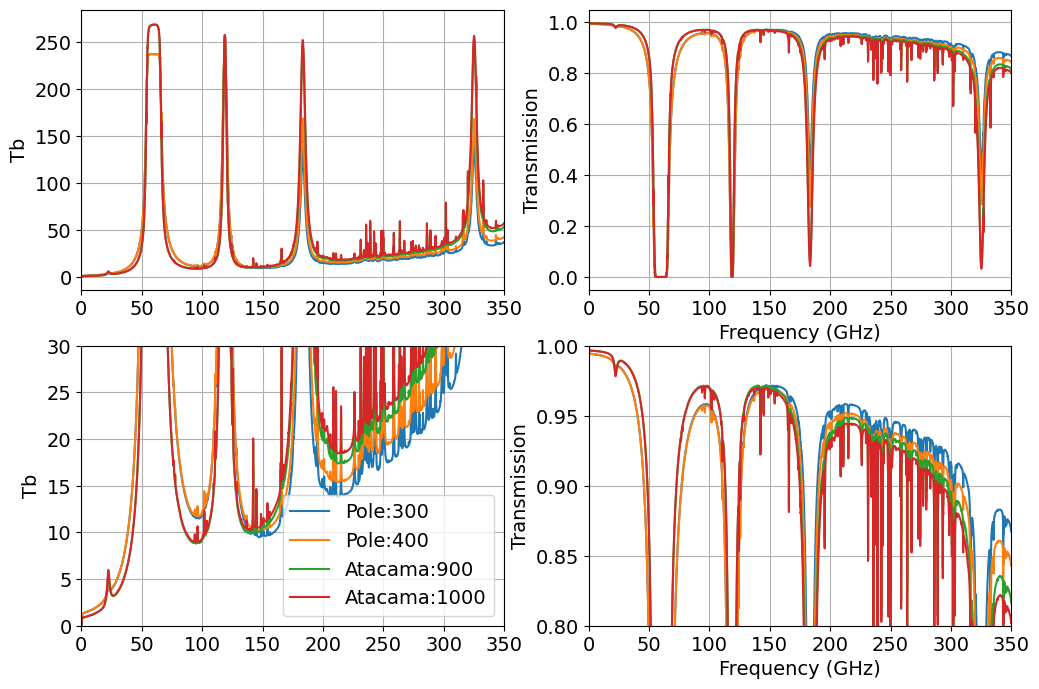

In [2]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [12, 8]

# Read in atmospheric data, plot it to see that it makes sense.
atmos = {}
read_atmospheres(atmos)

numax = 350
plt.subplot(2,2,1)
for site in ['Pole','Atacama']:
    for pwv in atmos[site].keys():
        plt.plot(atmos[site][pwv][0],atmos[site][pwv][5])
plt.ylabel('Tb') 
plt.xlim(0,numax)
plt.grid()

plt.subplot(2,2,2)
for site in ['Pole','Atacama']:
    for pwv in atmos[site].keys():
        plt.plot(atmos[site][pwv][0],atmos[site][pwv][2])
plt.ylabel('Transmission')
plt.xlabel('Frequency (GHz)')
plt.xlim(0,numax)
plt.grid()

plt.subplot(2,2,3)
for site in ['Pole','Atacama']:
    for pwv in atmos[site].keys():
        pltlabel=site+':'+str(pwv)
        #x=
        plt.plot(atmos[site][pwv][0],atmos[site][pwv][5],label=pltlabel)
plt.legend()
plt.ylabel('Tb') #or '$\delta Tb/ \delta pwv$
plt.xlim(0,numax)
plt.ylim(0,30)
plt.grid()

plt.subplot(2,2,4)
for site in ['Pole','Atacama']:
    for pwv in atmos[site].keys():
        plt.plot(atmos[site][pwv][0],atmos[site][pwv][2])
plt.ylabel('Transmission')
plt.xlabel('Frequency (GHz)')
plt.xlim(0,numax)
plt.ylim(0.8,1.0)
plt.grid()



In [96]:
#Spectrum only plot
#plt.rcParams.update({'font.size': 14})
#plt.rcParams['figure.figsize'] = [12, 8]

#for site in ['Pole','Atacama']:
 #   for pwv in atmos[site].keys():
  #      pltlabel=site+':'+str(pwv)+' um'
   #     plt.plot(atmos[site][pwv][0],atmos[site][pwv][5], label=pltlabel)
#plt.ylabel('Tb')
#plt.xlabel('Frequency (GHz)')
#plt.xlim(0,600)
#plt.grid()
#plt.legend()
#plt.title('Planck Brightness Temperature vs Frequency')

## Plot delta_Tb / delta_pwv (Original Way)


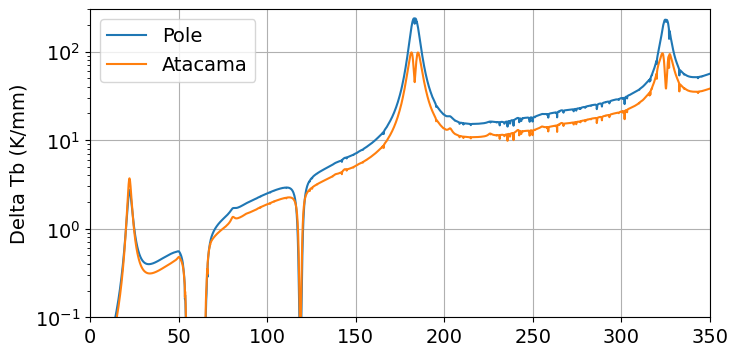

In [5]:
#original way of plotting without jacobian
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [8, 4]

# plot Tb differences between pwvs, which are 0.1mm pwv apart.
dpwv = 0.1 #mm
nuvec = atmos['Pole'][400][0]
Tbdiff_pole = (atmos['Pole'][400][5]-atmos['Pole'][300][5])/dpwv  #K/mm
Tbdiff_atacama = (atmos['Atacama'][1000][5]-atmos['Atacama'][900][5])/dpwv  #K/mm

plt.semilogy(nuvec,Tbdiff_pole,label='Pole')
plt.semilogy(nuvec,Tbdiff_atacama,label='Atacama')
plt.ylabel('Delta Tb (K/mm)')
plt.legend()
plt.xlim(0,350)
plt.ylim(0.1,300)
plt.grid()


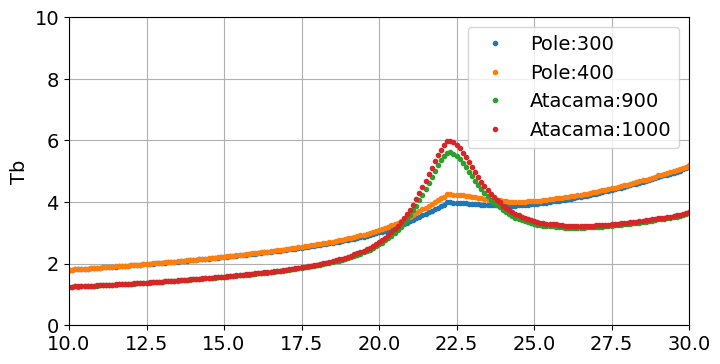

In [6]:
# Look at 22GHz water line more closely.
# Shape of Pole line is weird, maybe suspicious.  Should verify with direct am runs with
# better frequency resolution.

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [8, 4]

numax = 30

for site in ['Pole','Atacama']:
    for pwv in atmos[site].keys():
        pltlabel=site+':'+str(pwv)
        plt.plot(atmos[site][pwv][0],atmos[site][pwv][5],'.',label=pltlabel)
plt.legend()
plt.ylabel('Tb')
#plt.xlim(10,numax)
plt.xlim(10,30)
plt.ylim(0,10)
plt.grid()


## Plot delta_Tb / delta_pwv (Jacobian Way)

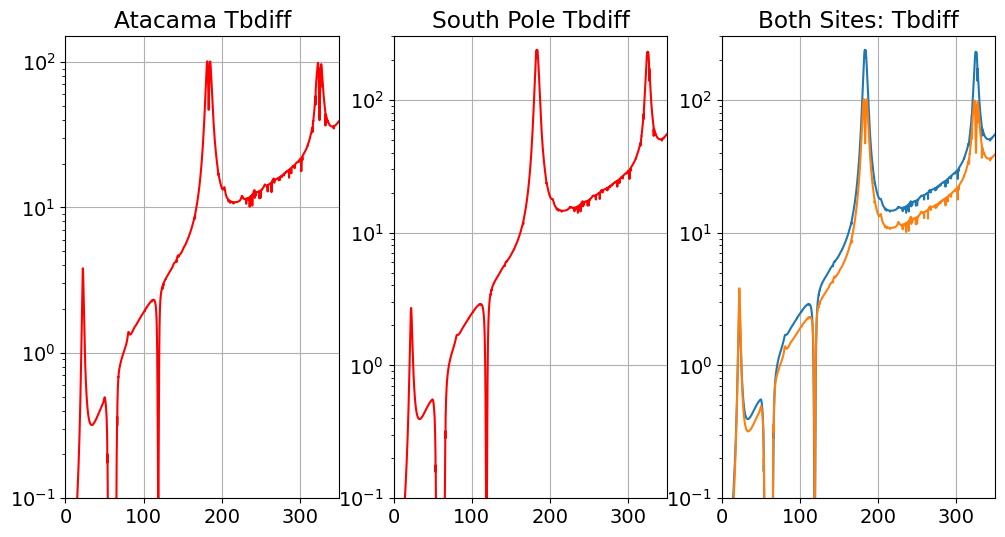

In [21]:
numax=350
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [12, 6]
#Atacama
plt.subplot(1,3,1)
act=(atmos['Atacama'][900][4]/0.932)+(atmos['Atacama'][1000][4]/0.932) 
#Another way to do this would be to get the 950 pwv value and scale accordingly
act_freq=atmos['Atacama'][900][0]
plt.semilogy(act_freq, act/2, color='red')
plt.ylim(0.1,150)
plt.xlim(0,numax)
plt.title('Atacama Tbdiff')
plt.grid()

#South Pole
plt.subplot(1,3,2)
sp=(atmos['Pole'][300][4]/0.425)+(atmos['Pole'][400][4]/0.425)
pole_freq=atmos['Pole'][300][0]
plt.semilogy(pole_freq, sp/2, color='red')
plt.ylim(0.1,300)
plt.xlim(0,numax)
plt.title('South Pole Tbdiff')
plt.grid()

#Both
plt.subplot(1,3,3)
plt.semilogy(pole_freq, sp/2)#, color='red')
plt.semilogy(act_freq, act/2)#, color='red')
plt.ylim(0.1,300)
plt.xlim(0,numax)
plt.title('Both Sites: Tbdiff')
plt.grid()
#plt.suptitle('Original and New Tb_diff values')

# Calculate g_pwv = delta_Tb/delta_pwv for a specified instrument band.

1. Define a single-moded detector's instrument band response:
  - F_inst($\nu$) = F_detector($\nu$) \* F_optics($\nu$)
  
  - The frequency-dependent factors F_detector and F_optics are numpy arrays.  They can come from:
    - a file
    - a flat band definition
    - a logistic band defition 
    - a power law "$\nu^\alpha$" model.  We note that an overilluminated Lyot stop gives alpha=2.
  
  
2. Find dPoptical_atmosphere/dpwv by appropriately integrating B_atmos($\nu$, T_b_atmos)*F_inst($\nu$).


3. Find dPoptical_dT_cmb using
  - F_tot($\nu$) = F_inst($\nu$) * F_atmos($\nu$)
  - Appropriately ntegrate delta_T_cmb * F_tot($\nu$) 
  
   
4. Take the ratio of those two, g_pwv = (dPopt_atmosphere/dpwv)/(dPopt_cmb/dT_cmb) = dT_cmb/dpwv .
  - Note that any overall factor in instrument efficiency common to the two factors will cancel in this ratio.  Thus, we don't worry about the overall normalization of the detector or optics efficiency, or whether we're using a single polarization or unpolarized detector.

# Example calculation of g_pwv 
For several related band models near 90GHz:
- a flat detector band, 
- a similar logistic band,
- a flat detector band times an optics alpha model

Site =  Pole
Band:  nu_low = 130.0, nu_high = 170.0
Bandmodel        dPdpwv      dPdTcmb       gpwv
Flat             8.541e-12   6.083e-13     14.042
Logistic:        9.073e-12   6.068e-13     14.952
Logistic*alpha:  9.846e-12   6.032e-13     16.324


Text(0.5, 1.0, 'Band Models at 150 GHz')

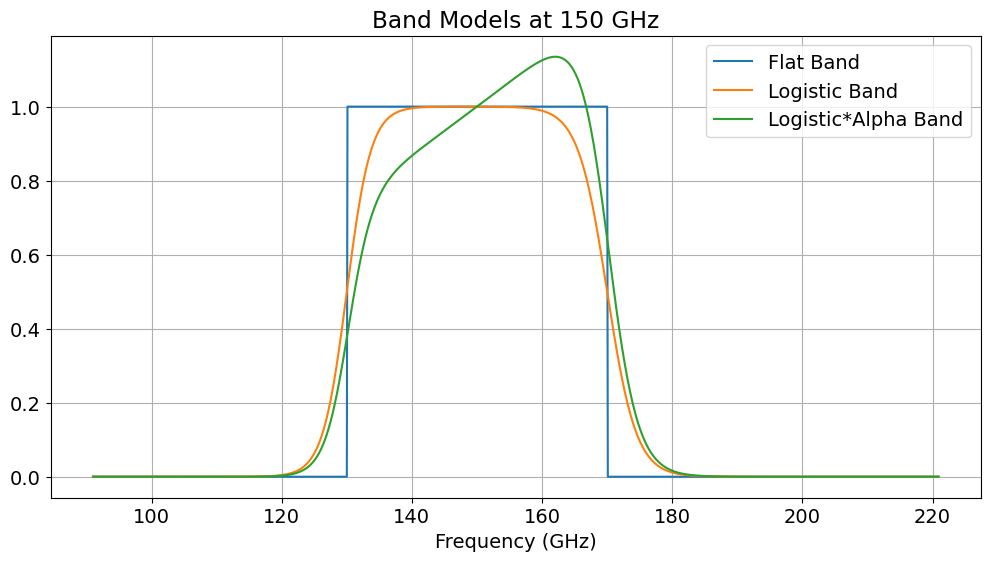

In [22]:
nu_lowedge = 130 # GHz
nu_highedge =170 
nu_center = (nu_lowedge+nu_highedge)/2
dnu = nu_highedge - nu_lowedge

# Integration frequency vector
nu_ghz = np.arange(nu_lowedge*0.7,nu_highedge*1.3,0.1) # full frequency vector over which to integrate.

# Choose site, and therefore the atmosphere
site = 'Pole'
pwv1 = list(atmos[site].keys())[0]  # assume we've got two pwv's loaded in!
pwv2 = list(atmos[site].keys())[1]
nu_atmos = atmos[site][pwv1][0]
Tb1 = atmos[site][pwv1][5]
Tb2 = atmos[site][pwv2][5]
atmos_trans = (atmos[site][pwv2][2]+atmos[site][pwv1][2])/2
dpwv = 0.1 #mm
# Interpolate Tb's to nu_ghz frequency points
Tb1_i = np.interp(nu_ghz,nu_atmos,Tb1)
Tb2_i = np.interp(nu_ghz,nu_atmos,Tb2)
atmos_trans_i = np.interp(nu_ghz,nu_atmos,atmos_trans)

print('Site = ',site)
print('Band:  nu_low = {0:4.1f}, nu_high = {1:4.1f}'.format(nu_lowedge, nu_highedge))
print('Bandmodel        dPdpwv      dPdTcmb       gpwv')

#flat band calculation
flat_band = flat_bandmodel(nu_ghz,nu_lowedge,nu_highedge)
dPdpwv = calc_dPdpwv(nu_ghz, Tb1_i, Tb2_i, dpwv, flat_band)
dPdTcmb = calc_dPdTcmb(nu_ghz, flat_band, atmos_trans_i)
gpwv= calc_gpwv(dPdpwv, dPdTcmb)
print('Flat             {0:4.3e}   {1:4.3e}     {2:4.3f}'.format(dPdpwv, dPdTcmb, gpwv))

#logistic band calculation
logistic_band = logistic_bandmodel(nu_ghz, nu_center, dnu, 2.0, 0.7)
dPdpwv = calc_dPdpwv(nu_ghz, Tb1_i, Tb2_i, dpwv, logistic_band)
dPdTcmb = calc_dPdTcmb(nu_ghz, logistic_band, atmos_trans_i)
gpwv= calc_gpwv(dPdpwv, dPdTcmb)
print('Logistic:        {0:4.3e}   {1:4.3e}     {2:4.3f}'.format(dPdpwv, dPdTcmb, gpwv))


#flat*alpha band calculation
alpha = 2
alpha_band = alpha_bandmodel(nu_ghz,nu_center,alpha)
total_band = alpha_band*logistic_band
dPdpwv = calc_dPdpwv(nu_ghz, Tb1_i, Tb2_i, dpwv, total_band)
dPdTcmb = calc_dPdTcmb(nu_ghz, total_band, atmos_trans_i)
gpwv= calc_gpwv(dPdpwv, dPdTcmb)
print('Logistic*alpha:  {0:4.3e}   {1:4.3e}     {2:4.3f}'.format(dPdpwv, dPdTcmb, gpwv))

# plot some things
plt.plot(nu_ghz,flat_band, label='Flat Band')
plt.plot(nu_ghz,logistic_band, label='Logistic Band')
plt.plot(nu_ghz,total_band, label='Logistic*Alpha Band')
#plt.plot(nu_ghz,3*Tb1_i/np.max(Tb1_i))
#plt.ylim(0,1.5)
plt.xlabel('Frequency (GHz)')
plt.grid()
plt.legend()
plt.title('Band Models at 150 GHz')


# Run a wide range of frequency centers and fractional bandwidths
This will give a global view of where bands should be placed, by this metric.

In [23]:
#make a function that does the work so we can later plot a bunch of frequency ranges in a single plot.
def make_one_plot(flow,fhigh,atmos):
    ncbins = 30 #20
    nwbins = 10
    
    # Choose site, and therefore the atmosphere
    site = 'Pole'
    pwv1 = list(atmos[site].keys())[0]  # assume we've got two pwv's loaded in!
    pwv2 = list(atmos[site].keys())[1]
    nu_atmos = atmos[site][pwv1][0]
    Tb1 = atmos[site][pwv1][5]
    Tb2 = atmos[site][pwv2][5]
    atmos_trans = (atmos[site][pwv2][2]+atmos[site][pwv1][2])/2
    dpwv = 0.1 #mm
    
    # choose x-axis, center frequencies to do this over
    band_center_vec = np.linspace(flow,fhigh,ncbins) #centerfreq log space
    frac_bandwidth_vec = np.linspace(0.01,0.5,nwbins) #0.1, 0.4, 
    
    # Set up 2D arrays for plotting
    outdata={
        'center': np.empty((ncbins,nwbins)),
        'fwidth'  :  np.empty((ncbins,nwbins)),
        'highedge':  np.empty((ncbins,nwbins)),
        'lowedge' :  np.empty((ncbins,nwbins)),
        'gpwv'    :  np.empty((ncbins,nwbins)),
        'dPdTcmb' :  np.empty((ncbins,nwbins)),
        'dPdpwv'  :  np.empty((ncbins,nwbins))
        }
    
    cc = 0 # center index
    for center in band_center_vec:
        ww = 0  # width index
        for fwidth in frac_bandwidth_vec:
            # Set up frequency vector and associated band definition quantities
            nu_lowedge =  center*(1 - fwidth/2)  # these are edges of band;  integration extends beyond them.
            nu_highedge = center*(1 + fwidth/2)
            nu_center = (nu_lowedge+nu_highedge)/2
            delta_nu = nu_highedge - nu_lowedge 
            nu_low = 0.7*nu_lowedge
            nu_high = 1.3*nu_highedge
            nu_ghz = np.linspace(nu_low,nu_high, 1000)  # full integration band, make it 1000pts.
    
            # Interpolate Tb's to nu_ghz frequency points
            Tb1_i = np.interp(nu_ghz,nu_atmos,Tb1)
            Tb2_i = np.interp(nu_ghz,nu_atmos,Tb2)
            atmos_trans_i = np.interp(nu_ghz,nu_atmos,atmos_trans)
            outdata['center'][cc][ww] = center
            outdata['fwidth'][cc][ww] = fwidth
            outdata['lowedge'][cc][ww] = nu_lowedge
            outdata['highedge'][cc][ww] = nu_highedge
            
            
            flat_band = flat_bandmodel(nu_ghz,nu_lowedge,nu_highedge)
            logistic_band = logistic_bandmodel(nu_ghz, nu_center, delta_nu, 2.0, 0.7)
            alpha_band = alpha_bandmodel(nu_ghz,nu_center,alpha)
            # Choose one of the above, here.
            total_band = logistic_band*alpha_band
    
            dPdpwv = calc_dPdpwv(nu_ghz, Tb1_i, Tb2_i, dpwv, total_band)
            dPdTcmb = calc_dPdTcmb(nu_ghz, total_band, atmos_trans_i)
            gpwv= dPdpwv/dPdTcmb
            #gpwv= dPdpwv/dPdTcmb
            
            outdata['dPdpwv'][cc][ww]=dPdpwv
            outdata['dPdTcmb'][cc][ww]=dPdTcmb
            outdata['gpwv'][cc][ww] = calc_gpwv(dPdpwv, dPdTcmb)
            ww += 1
        cc += 1
    return outdata

def plot_one_panel(outdata,axs,rownum,minval,maxval,clevels):
    min_c = outdata['center'][0][0]
    max_c = outdata['center'][-1][-1]
    min_w = outdata['fwidth'][0][0]
    max_w = outdata['fwidth'][-1][-1]
    
    band_center_vec = outdata['center'][:,0]
    frac_bandwidth_vec = outdata['fwidth'][0,:]
    
    data = np.abs(outdata['gpwv'].T)
    print('data shape',data.shape)
    f_aspect = 2.0*(max_c-min_c)
    abc = axs[rownum].imshow(data,origin='lower',vmin=minval,aspect=f_aspect,vmax=maxval,interpolation='bilinear',extent=(min_c, max_c, min_w, max_w))

    cset = axs[rownum].contour(band_center_vec,frac_bandwidth_vec,data,levels=clevels,colors='w')
    axs[rownum].clabel(cset)
    
    #divider = make_axes_locatable(axs[rownum])
    #cax = divider.append_axes('top' , size='5%', pad='1%')
    #axs[rownum,colnum].scatter(sim['channels'][ch]['nu_center0'],sim['channels'][ch]['nu_width0'],s=200,marker='x',c='m')
    #fig.colorbar(abc, cax,orientation='horizontal')
    
    axs[rownum].set_xlabel('Center frequency (GHz)')
    #axs[rownum].set_ylabel('Fractional bandwidth')
    axs[rownum].grid()

data shape (10, 30)
data shape (10, 30)
data shape (10, 30)
data shape (10, 30)


Text(0, 0.5, 'Fractional Bandwidth')

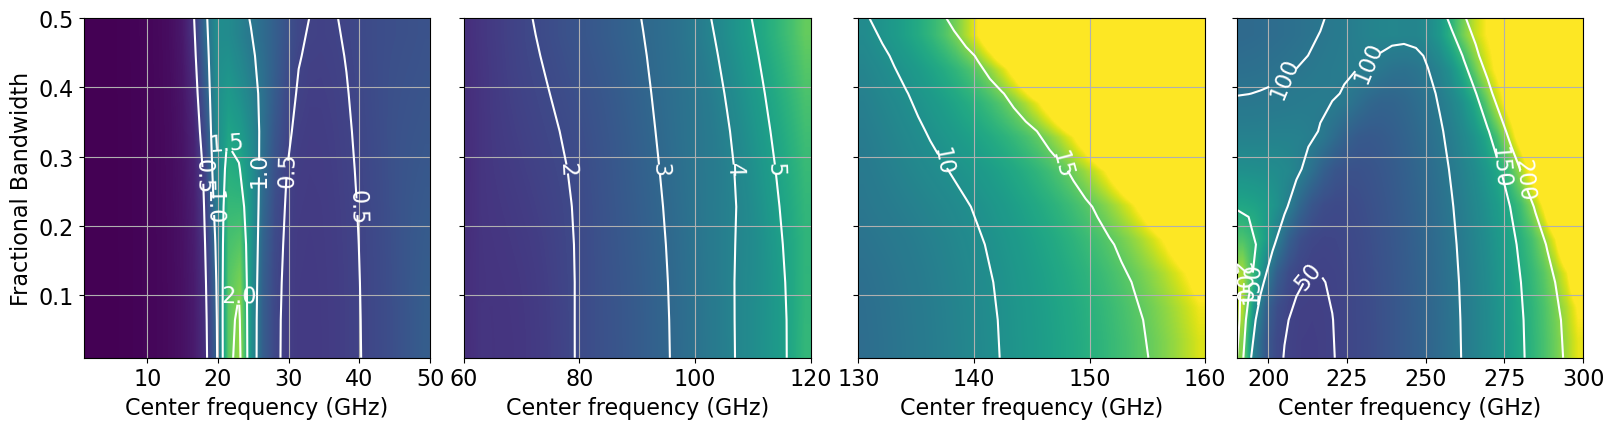

In [25]:
#make sure the bandmodel is defined in the function above
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [16, 12]

fig,axs = plt.subplots(nrows=1,ncols=4,sharey=True,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=2 / 72, h_pad=2 / 72, hspace=0.1,wspace=0.0)

outdat = make_one_plot(1,50,atmos)
plot_one_panel(outdat,axs,0,0,2.5,[0,0.5,1,1.5,2])

outdat = make_one_plot(60,120,atmos)
plot_one_panel(outdat,axs,1,0,9,[0,1,2,3,4,5])

outdat = make_one_plot(130,160,atmos)
plot_one_panel(outdat,axs,2,0,20,[0,5,10,15])

outdat = make_one_plot(190,300,atmos)
plot_one_panel(outdat,axs,3,0,250,[0,50,100,150,200])
axs[0].set_ylabel('Fractional Bandwidth')
#fig.suptitle('g_pwv for South Pole (Flat Model)')

data shape (10, 30)
data shape (10, 30)
data shape (10, 30)
data shape (10, 30)


Text(0, 0.5, 'Fractional Bandwidth')

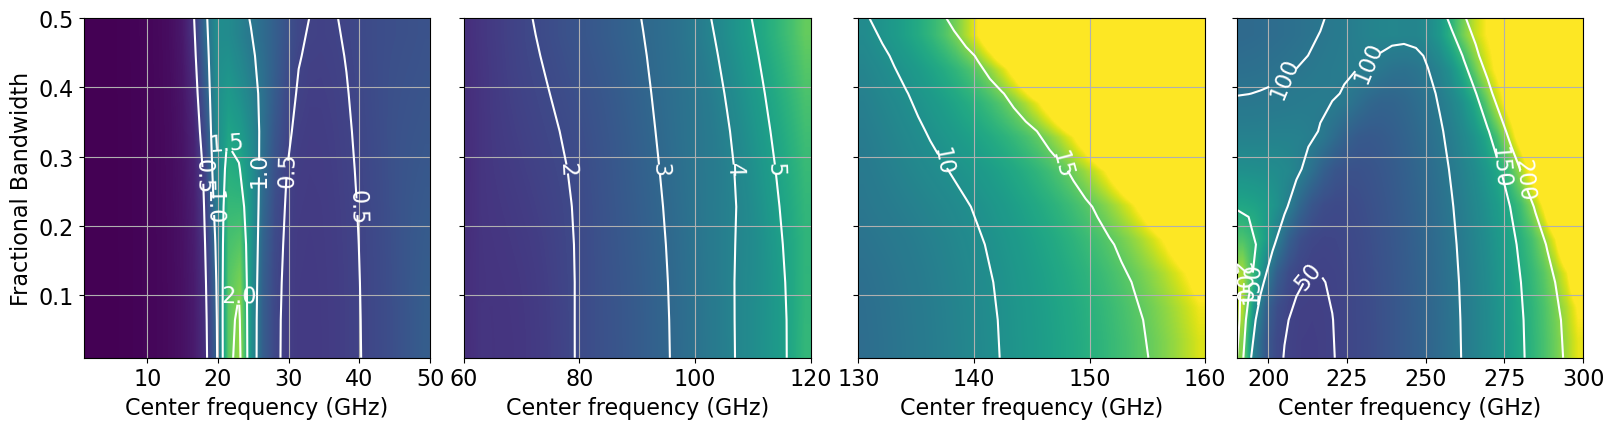

In [26]:
#rerun for Logisitic
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [16, 12]

fig,axs = plt.subplots(nrows=1,ncols=4,sharey=True,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=2 / 72, h_pad=2 / 72, hspace=0.1,wspace=0.0)

outdat = make_one_plot(1,50,atmos)
plot_one_panel(outdat,axs,0,0,2.5,[0,0.5,1,1.5,2])

outdat = make_one_plot(60,120,atmos)
plot_one_panel(outdat,axs,1,0,9,[0,1,2,3,4,5])

outdat = make_one_plot(130,160,atmos)
plot_one_panel(outdat,axs,2,0,20,[0,5,10,15])

outdat = make_one_plot(190,300,atmos)
plot_one_panel(outdat,axs,3,0,250,[0,50,100,150,200])
axs[0].set_ylabel('Fractional Bandwidth')
#plt.suptitle('gpwv SPole (Logistic Model)')

data shape (10, 30)
data shape (10, 30)
data shape (10, 30)
data shape (10, 30)


Text(0.5, 0.7, 'gpwv SPole (Logistic Model*Alpha)')

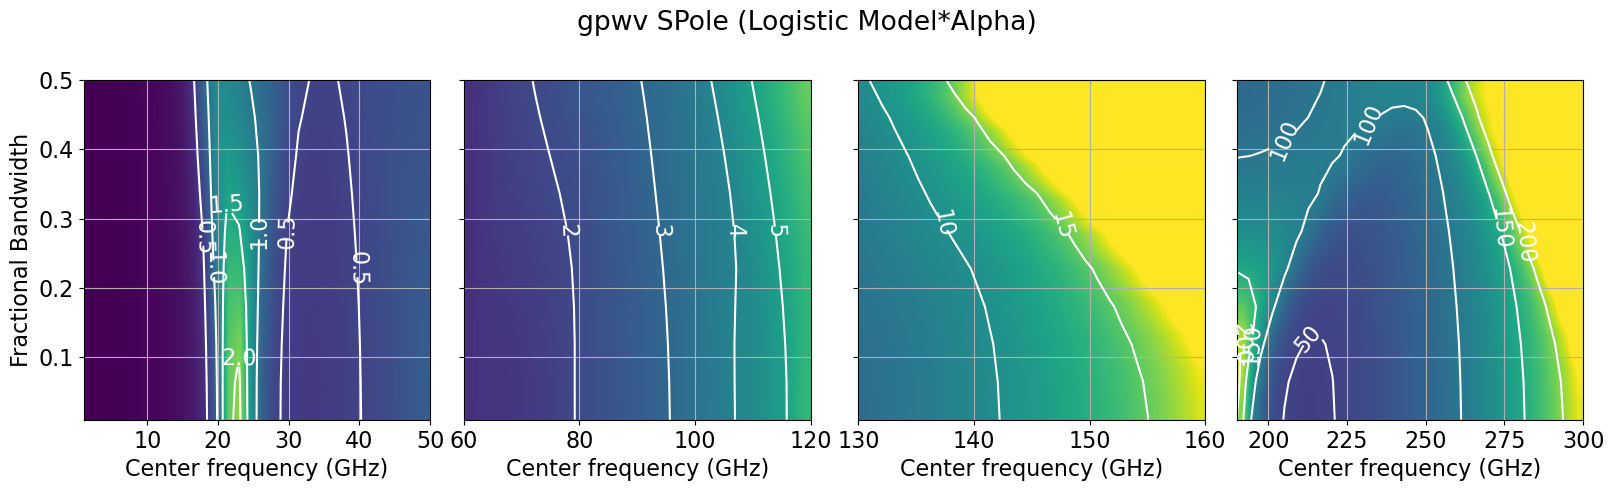

In [27]:
#rerun for Logisitic * alpha = 2
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [16, 12]

fig,axs = plt.subplots(nrows=1,ncols=4,sharey=True,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=2 / 72, h_pad=2 / 72, hspace=0.1,wspace=0.0)

outdat = make_one_plot(1,50,atmos)
plot_one_panel(outdat,axs,0,0,2.5,[0,0.5,1,1.5,2])

outdat = make_one_plot(60,120,atmos)
plot_one_panel(outdat,axs,1,0,9,[0,1,2,3,4,5])

outdat = make_one_plot(130,160,atmos)
plot_one_panel(outdat,axs,2,0,20,[0,5,10,15])

outdat = make_one_plot(190,300,atmos)
plot_one_panel(outdat,axs,3,0,250,[0,50,100,150,200])
axs[0].set_ylabel('Fractional Bandwidth')
plt.suptitle('gpwv SPole (Logistic Model*Alpha)', y=0.70)

In [11]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [12, 4]

nrows = 4
flows = [1,60,]

fig.suptitle('g_pwv (K_cmb/mm)')

Text(0.5, 0.98, 'g_pwv (K_cmb/mm)')

It would be nice to make the plot above with log frequency on the x-axis, but that requires some fancy axis-labeling.


In [28]:
#plt.plot(band_center_vec,out_center.T[10,:],'.')
#plt.plot(band_center_vec,out_center.T[90,:],'.')
#plt.grid()

# Read in band information from a yaml file
(using same dictionary format as jbolo, for compatibility)

In [29]:
sim = yaml.safe_load(open('channels.yaml'))

In [30]:
sim['channels']

{'ULF': {'chnum': 0, 'band_center': 20.0, 'nu_low': 17.5, 'nu_high': 22.5},
 'LF_1': {'chnum': 1, 'band_center': 25.75, 'nu_low': 21.5, 'nu_high': 30.0},
 'LF_2': {'chnum': 2, 'band_center': 38.75, 'nu_low': 29.99, 'nu_high': 47.51},
 'MF_1': {'chnum': 3, 'band_center': 91.5, 'nu_low': 77.0, 'nu_high': 106.0},
 'MF_2': {'chnum': 4, 'band_center': 148.5, 'nu_low': 128.0, 'nu_high': 169.0},
 'HF_1': {'chnum': 5,
  'band_center': 227.0,
  'nu_low': 197.94,
  'nu_high': 256.06},
 'HF_2': {'chnum': 6,
  'band_center': 285.5,
  'nu_low': 255.95,
  'nu_high': 315.05}}

Text(0.5, 1.0, 'Model 1: Logistic LF1 Band')

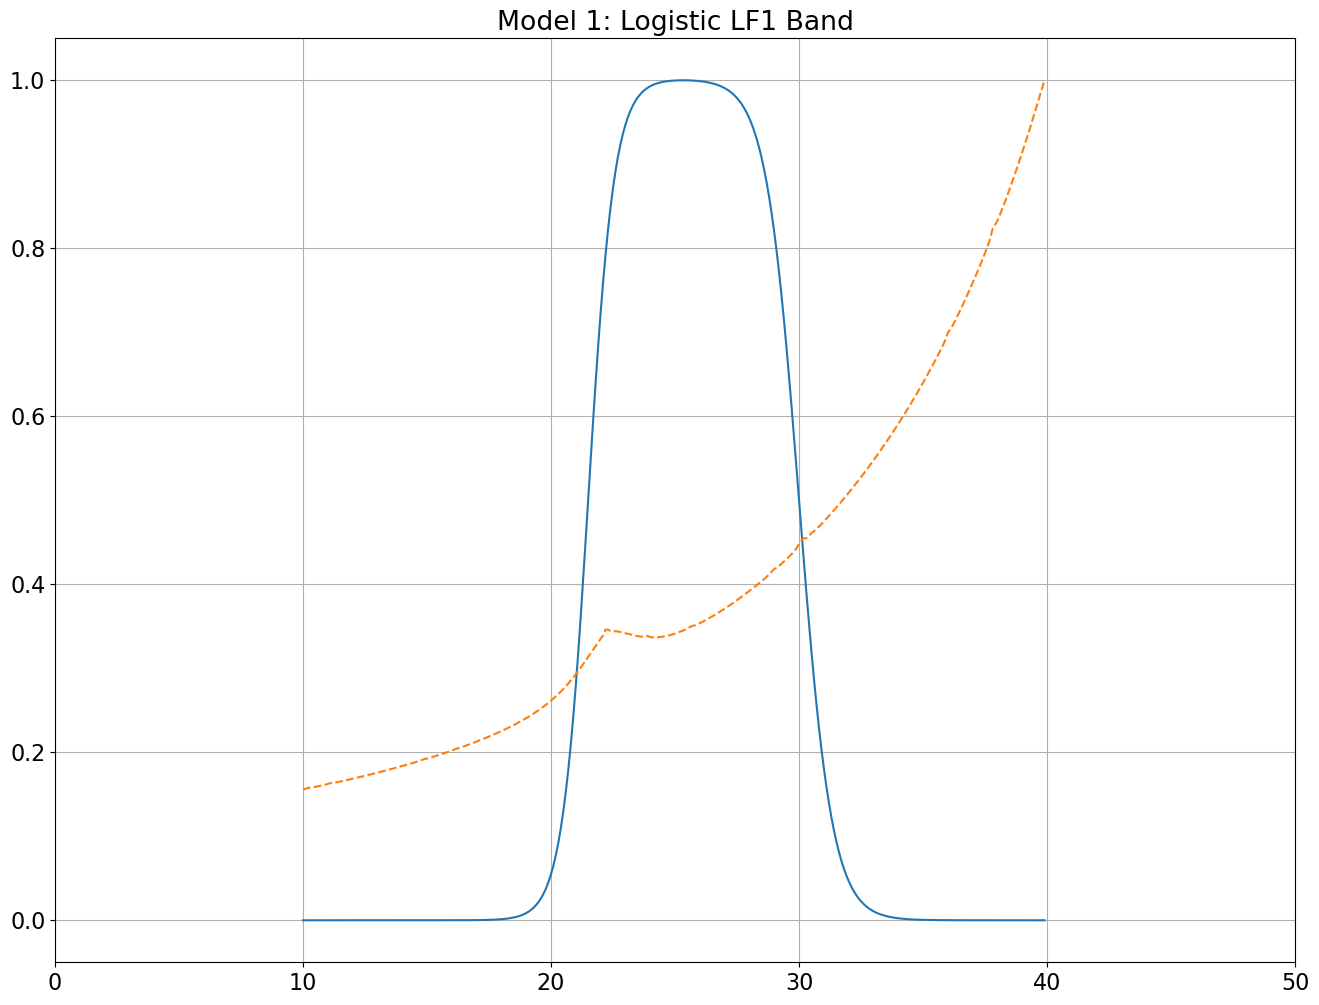

In [31]:
#test run to see band shape with logistic model
# Create our own frequency vector, over which we'll integrate.
# Make the logistic band model directly on that vector.
# Interpolate the atmospheric Tb's to that vector.

nuvec = np.arange(10,40,0.1) # frequency vector, interpolate atmos to this.
dnu= sim['channels']['LF_1']['nu_high']-sim['channels']['LF_1']['nu_low']
bandcenter = sim['channels']['LF_1']['band_center']
bandmodel = logistic_bandmodel(nuvec, bandcenter, dnu, 2.0, 0.7)
nu_atmos = atmos['Pole'][300][0]
Tb_atmos = atmos['Pole'][300][5]
Tb_interp = np.interp(nuvec,nu_atmos,Tb_atmos)

plt.plot(nuvec,bandmodel)
plt.plot(nuvec,Tb_interp/np.max(Tb_interp),'--')
plt.xlim(0,50)
plt.grid()
plt.title('Model 1: Logistic LF1 Band')

Comment on plot above:

- we might want to make band smaller for LF so we are not integrating over the whole thing (all freq)

# This is where we begin Testing and Incorporating our Python Functions
We first want to define what our model is similar to above, from there we can run the other functions to get specfic values, then we can put them all into a dictionary so we can call them later for plotting.

In [32]:
#This cell defines intial parameters for our instrument band model and atmospheric transmission
#we will be using the new am files for this section, but you can also use CH's data cube or other files

bandcenter = sim['channels']['LF_1']['band_center']
nulow=sim['channels']['LF_1']['nu_low']*0.7
nuhigh=sim['channels']['LF_1']['nu_high']*1.3
nuvec = np.arange(nulow, nuhigh, 0.1) # frequency vector, interpolate atmos to this.
dnu= sim['channels']['LF_1']['nu_high']-sim['channels']['LF_1']['nu_low']

nu_atmos = atmos['Pole'][300][0]
atmos_trans = atmos['Pole'][300][2]
atmos_trans_interp = np.interp(nuvec,nu_atmos,atmos_trans)
Tb_atmos1 = atmos['Pole'][300][5]
Tb_interp = np.interp(nuvec,nu_atmos,Tb_atmos1)
Tb_atmos2 = atmos['Pole'][400][5]
Tb_interp2= np.interp(nuvec,nu_atmos,Tb_atmos2)

dpwv = 0.1 # mm

a=2
n=0.7
alpha= 2 # 0 or 2

In [33]:
bandmodel = logistic_bandmodel(nuvec, bandcenter, dnu, a, n)*alpha_bandmodel(nuvec, bandcenter, alpha)#*atmos_trans

Text(0.5, 1.0, 'Band Model 2: Logistic+Optics for LF1')

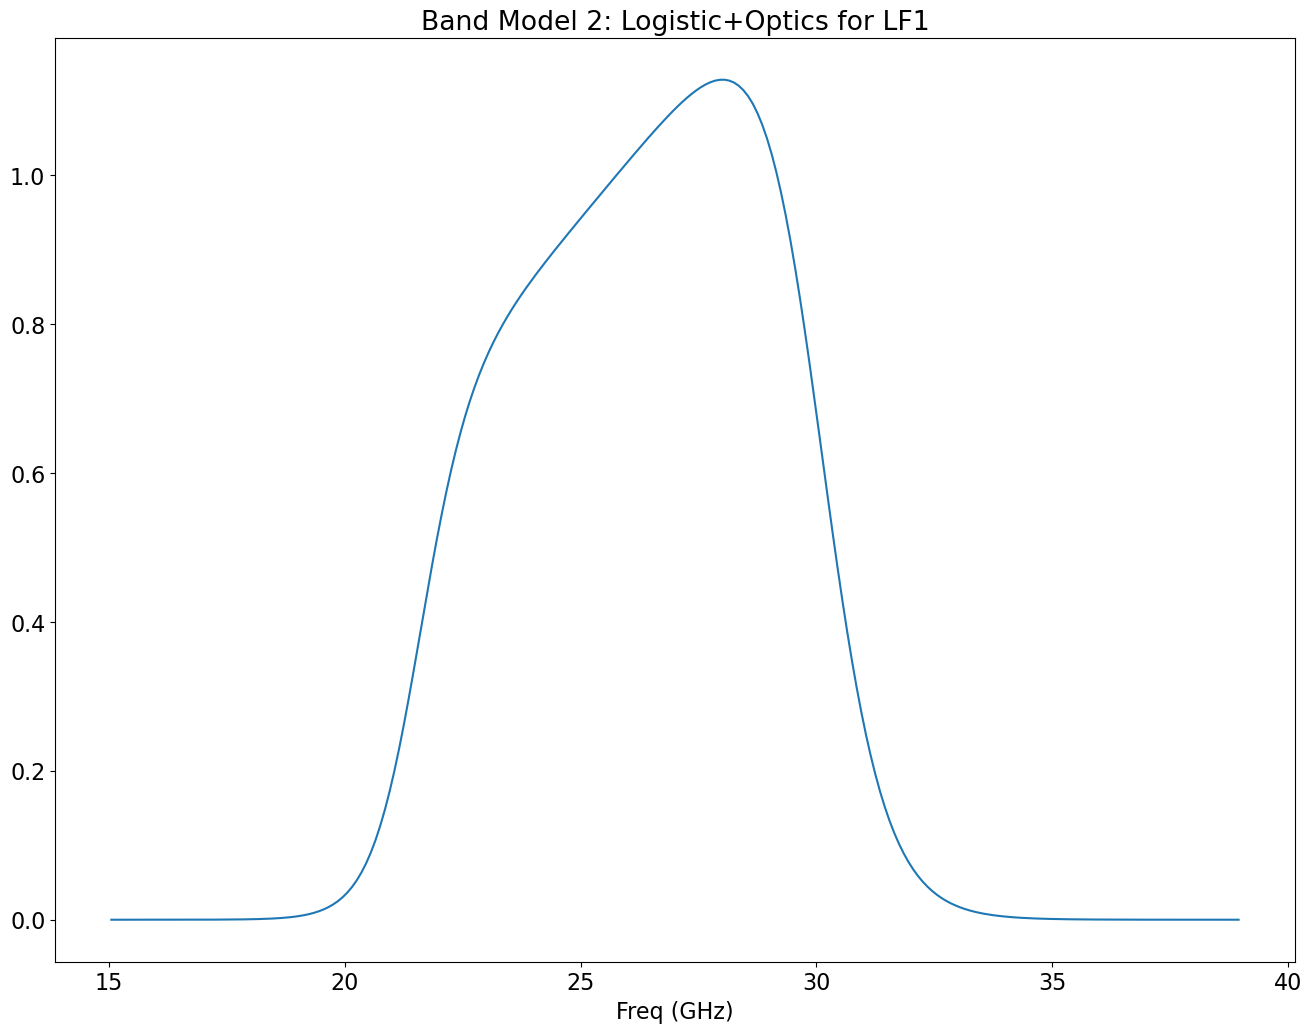

In [34]:
#this is the instrument and optics band model 
plt.plot(nuvec, bandmodel)
plt.xlabel('Freq (GHz)')
plt.title('Band Model 2: Logistic+Optics for LF1')#+ ch)

In [35]:
dpdtcmb= calc_dPdTcmb(nuvec, bandmodel, atmos_trans_interp)
print('dPdTcmb:', dpdtcmb)

dPdTcmb: 2.3002381961847274e-13


In [36]:
dPdpwv= calc_dPdpwv(nuvec, Tb_interp, Tb_interp2, dpwv, bandmodel)
print('dPdpwv:', dPdpwv)

dPdpwv: 2.345061112709386e-13


In [37]:
gpwv= calc_gpwv(dPdpwv, dpdtcmb)
print('gpwv:', gpwv)

gpwv: 1.0194862065150487


These are previous gpwv results for Pole at 300 and 400 um pwv:

1.122368744313282, 1.1707764662372104
<br>1.109273860925371, 1.157481276402308
<br>0.43580808244702285, 0.4563716164235642
<br>2.4419921980252965, 2.556993622960584
<br>12.825834088708984, 13.350005243407248
<br>54.11917318835391, 56.17281294172888
<br>166.1904136365731, 170.3894376628703

dPdTcmb:
<br>1.3661235964755087e-13 1.3661235964755087e-13
<br>2.306039014463887e-13 2.306039014463887e-13
<br>4.642291404321928e-13 4.642291404321928e-13
<br>6.445851145073793e-13 6.445851145073793e-13
<br>6.533097901070082e-13 6.533097901070082e-13
<br>4.839831617855115e-13 4.839831617855115e-13
<br>2.69708647175781e-13 2.69708647175781e-13

dPdpwv:
<br>1.5332944255529613e-13 1.5994253567248648e-13
<br>2.558028801018893e-13 2.66919698189518e-13
<br>2.0231481150778365e-13 2.1186100320996165e-13
<br>1.5740718205902628e-12 1.6482000272506868e-12
<br>8.379242976441777e-12 8.721689123497848e-12
<br>2.6192768552917207e-11 2.718669561392404e-11
<br>4.48229916355036e-11 4.595550472509482e-11

Given the results, the functions seem to be working well. Have @John check to make sure fxns are all correct.

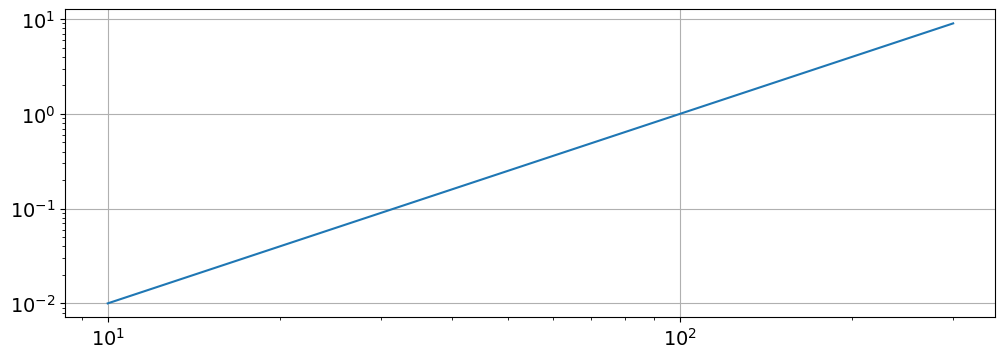

In [34]:
#this section visualizes the alpha bandmodel function, play with the alpha parameter (0 or 2)

nughz = np.linspace(10,300,100)
nu0 = 100 # GHz.3
#alpha = 2

band=alpha_bandmodel(nughz,nu0, 2)
plt.loglog(nughz,band)
plt.grid()

# Calculate and save gpwv values through all bands 
The following cells take portion of previous nbs and calculate gpwv values for each band and then save them into two dictionaries where they can be called to plot. We are able to look at high and low edge pwv values as well as center pwv values.

In [39]:
#South Pole Dict, run once
a = 2.0
n = 0.7
alpha= 2  #can be 0 or 2

chlist = list(sim['channels'].keys())
spole_dict={}
spole_pwvs=[300]#, 400]
#for site in ['Pole','Atacama']:
for pwv in spole_pwvs:
    spole_dict[pwv]={}
    for ch in chlist:
        spole_dict[pwv][ch]={}
        bandcenter = sim['channels'][ch]['band_center']
        nu_atmos = atmos['Pole'][pwv][0]
        nulow=sim['channels'][ch]['nu_low']
        nuhigh= sim['channels'][ch]['nu_high']
        dnu= nuhigh-nulow
        nuvec = np.arange(nulow*0.7,nuhigh*1.3,0.1)
        atmos_trans = atmos['Pole'][pwv][2]
        atmos_trans_interp = np.interp(nuvec,nu_atmos,atmos_trans)
        Tb_atmos1 = atmos['Pole'][pwv][5]
        Tb_interp = np.interp(nuvec,nu_atmos,Tb_atmos1)
        Tb_atmos2 = atmos['Pole'][pwv+100][5]
        Tb_interp2= np.interp(nuvec,nu_atmos,Tb_atmos2)
        bandmodel = logistic_bandmodel(nuvec, bandcenter, dnu, a, n)*alpha_bandmodel(nuvec, bandcenter, alpha)
        dPdpwv = calc_dPdpwv(nuvec, Tb_interp, Tb_interp2, dpwv, bandmodel)
        dPdTcmb = calc_dPdTcmb(nuvec, bandmodel, atmos_trans_interp)
        gpwv= dPdpwv/dPdTcmb
        
        spole_dict[pwv][ch]['freqvec']= nuvec
        spole_dict[pwv][ch]['tbvec']= Tb_interp
        spole_dict[pwv][ch]['high_edge_0']= nuhigh
        spole_dict[pwv][ch]['low_edge_0']= nulow
        spole_dict[pwv][ch]['bandshape']= bandmodel#*atmos_trans_interp
        spole_dict[pwv][ch]['bandcenter']= bandcenter
        spole_dict[pwv][ch]['bandwidth']= nuhigh-nulow
        spole_dict[pwv][ch]['dPdTcmb']= dPdTcmb
        spole_dict[pwv][ch]['dPdpwv']= dPdpwv
        spole_dict[pwv][ch]['gpwv']= (dPdpwv/dPdTcmb)
        
        #look into .py file and edit
        npts=50
        freqvec_high= np.linspace(nuhigh-(nuhigh*0.1), nuhigh+(nuhigh*0.1), npts)
        dPdTcmb_h= np.array([])
        dPdpwv_h= np.array([])
        gpwv_h= np.array([])
   
        nu= nuvec*1e9 
        dB_dT= dBdT(2.7, nu) ##take outside loop
        for freqhigh in freqvec_high: 
           
            model1 = logistic_easy(nuvec, nulow, freqhigh, a, n)*alpha_bandmodel(nuvec, nulow, alpha)*atmos_trans_interp
            dPdTcmb= np.trapz(model1*dB_dT*(c**2/nu**2), nu)
            dPdTcmb_h= np.append(dPdTcmb_h, dPdTcmb)
            
            P_atm0 = np.trapz(model1*bnu_aomega(nu, Tb_interp), nu) 
            P_atm1 = np.trapz(model1*bnu_aomega(nu, Tb_interp2), nu) 
            dPdpwv = (P_atm1-P_atm0)/0.1
            dPdpwv_h= np.append(dPdpwv_h,dPdpwv)
            
            gpwv_h= np.append(gpwv_h, dPdpwv/dPdTcmb)
                  
        freqvec_low= np.linspace(nulow-(nulow*0.1), nulow+(nulow*0.1), npts)
        dPdTcmb_l= np.array([])
        dPdpwv_l= np.array([])
        gpwv_l= np.array([])
   
        for freqlow in freqvec_low: 
            #nu= nuvec*1e9
            model1 = logistic_easy(nuvec, nuhigh, freqlow, a, n)*alpha_bandmodel(nuvec, nuhigh, alpha)*atmos_trans_interp
            #dB_dT= dBdT(2.7, nu)

            dPdTcmb_l= np.append(dPdTcmb_l, np.trapz(model1*dB_dT*(c**2/nu**2), nu))
            P_atm0 = np.trapz(model1*bnu_aomega(nu, Tb_interp), nu) 
            P_atm1 = np.trapz(model1*bnu_aomega(nu, Tb_interp2), nu)                 
            dPdpwv_l= np.append(dPdpwv_l, (P_atm1-P_atm0)/0.1)
        #print(dPdpwv_l)
        #print(dPdTcmb_l)
    
        spole_dict[pwv][ch]['lowvec']= freqvec_low
        spole_dict[pwv][ch]['highvec']= freqvec_high
        
        spole_dict[pwv][ch]['dPdTcmb_l'] = dPdTcmb_l
        spole_dict[pwv][ch]['dPdTcmb_h'] = dPdTcmb_h
        
        spole_dict[pwv][ch]['dPdpwv_l'] = dPdpwv_l
        spole_dict[pwv][ch]['dPdpwv_h'] = dPdpwv_h
        
        spole_dict[pwv][ch]['gpwv_l'] = dPdpwv_l/dPdTcmb_l
        spole_dict[pwv][ch]['gpwv_h'] = dPdpwv_h/dPdTcmb_h

In [36]:
print(spole_dict[300]['HF_1']['gpwv_l'])
print(spole_dict[300]['HF_1']['gpwv_h'])

[175.33499364 176.95964539 176.65964152 174.34659323 170.06626864
 164.00233856 156.45621714 147.8074943  138.46720427 128.83471519
 119.26559937 110.05144961 101.4109915   93.49021928  86.36934639
  80.07403434  74.58843606  69.8679934   65.85059599  62.46540721
  59.63930571  57.30119106  55.38459713  53.8291022   52.58090022
  51.59284944  50.82420871  50.24021357  49.81159588  49.51408663
  49.32790048  49.23717243  49.22932162  49.29436098  49.42421299
  49.61210739  49.85212064  50.13887814  50.46739719  50.83302901
  51.23145542  51.65870279  52.11115044  52.58552355  53.07887075
  53.58853187  54.11210202  54.64739717  55.19242306  55.74534761]
[48.32537755 48.50351299 48.69329608 48.89534681 49.1104885  49.33959317
 49.58342372 49.8424816  50.11688667 50.4063233  50.71007987 51.02718377
 51.35659335 51.69738567 52.0488933  52.41078275 52.78308443 53.16617316
 53.56067935 53.96732623 54.38672569 54.81919752 55.26467823 55.72275165
 56.19278178 56.67409949 57.16617217 57.6687033

In [40]:
#Atacama Dict, run once
a = 2.0
n = 0.7
alpha= 2  #can be 0 or 2

chlist = list(sim['channels'].keys())
atacama_dict={}
atacama_pwvs=[900]#, 1000]
dpwv = 0.1 #mm
#for site in ['Pole','Atacama']:
for pwv in atacama_pwvs:
    atacama_dict[pwv]={}
    for ch in chlist:
        atacama_dict[pwv][ch]={}
        bandcenter = sim['channels'][ch]['band_center']
        nu_atmos = atmos['Atacama'][pwv][0]
        nulow=sim['channels'][ch]['nu_low']
        nuhigh= sim['channels'][ch]['nu_high']
        dnu= nuhigh-nulow
        nuvec = np.arange(nulow*0.7,nuhigh*1.3,0.1)
        atmos_trans = atmos['Atacama'][pwv][2]
        atmos_trans_interp = np.interp(nuvec,nu_atmos,atmos_trans)
        Tb_atmos1 = atmos['Atacama'][pwv][5]
        Tb_interp = np.interp(nuvec,nu_atmos,Tb_atmos1)
        Tb_atmos2 = atmos['Atacama'][pwv+100][5]
        Tb_interp2= np.interp(nuvec,nu_atmos,Tb_atmos2)
        bandmodel = logistic_bandmodel(nuvec, bandcenter, dnu, a, n)*alpha_bandmodel(nuvec, bandcenter, alpha)
        dPdpwv = calc_dPdpwv(nuvec, Tb_interp, Tb_interp2, dpwv, bandmodel)
        dPdTcmb = calc_dPdTcmb(nuvec, bandmodel, atmos_trans_interp)
        gpwv= dPdpwv/dPdTcmb
        
        atacama_dict[pwv][ch]['freqvec']= nuvec
        atacama_dict[pwv][ch]['tbvec']= Tb_interp
        atacama_dict[pwv][ch]['high_edge_0']= nuhigh
        atacama_dict[pwv][ch]['low_edge_0']= nulow
        atacama_dict[pwv][ch]['bandshape']= bandmodel#*atmos_trans_interp
        atacama_dict[pwv][ch]['bandcenter']= bandcenter
        atacama_dict[pwv][ch]['bandwidth']= nuhigh-nulow
        atacama_dict[pwv][ch]['dPdTcmb']= dPdTcmb
        atacama_dict[pwv][ch]['dPdpwv']= dPdpwv
        atacama_dict[pwv][ch]['gpwv']= (dPdpwv/dPdTcmb)
        
        npts=50
        freqvec_high= np.linspace(nuhigh-(nuhigh*0.1), nuhigh+(nuhigh*0.1), npts)
        dPdTcmb_h= np.array([])
        dPdpwv_h= np.array([])
        gpwv_h= np.array([])
   
        nu= nuvec*1e9
        dB_dT= dBdT(2.7, nu)
        for freqhigh in freqvec_high: 
            model1 = logistic_easy(nuvec, nulow, freqhigh, a, n)*alpha_bandmodel(nuvec, nulow, alpha)*atmos_trans_interp
            #print(model1)
            dPdTcmb_h= np.append(dPdTcmb_h, np.trapz(model1*dB_dT*(c**2/nu**2), nu))
            
            P_atm0 = np.trapz(model1*bnu_aomega(nu, Tb_interp), nu) 
            P_atm1 = np.trapz(model1*bnu_aomega(nu, Tb_interp2), nu)                 
            dPdpwv_h= np.append(dPdpwv_h, (P_atm1-P_atm0)/0.1)
            #gpwv_h= np.append(gpwv_h, dPdpwv_h/dPdTcmb_h)
                  
        freqvec_low= np.linspace(nulow-(nulow*0.1), nulow+(nulow*0.1), npts)
        dPdTcmb_l= np.array([])
        dPdpwv_l= np.array([])
        gpwv_l= np.array([])
   
        for freqlow in freqvec_low: 
            #nu= nuvec*1e9
            model1 = logistic_easy(nuvec, nuhigh, freqlow, a, n)*alpha_bandmodel(nuvec, nuhigh, alpha)*atmos_trans_interp
            #dB_dT= dBdT(2.7, nu)

            dPdTcmb_l= np.append(dPdTcmb_l, np.trapz(model1*dB_dT*(c**2/nu**2), nu))
            P_atm0 = np.trapz(model1*bnu_aomega(nu, Tb_interp), nu) 
            P_atm1 = np.trapz(model1*bnu_aomega(nu, Tb_interp2), nu)                 
            dPdpwv_l= np.append(dPdpwv_l, (P_atm1-P_atm0)/0.1)
        
        #print(dPdpwv_l)
        #print(dPdTcmb_l)
    
        atacama_dict[pwv][ch]['lowvec']= freqvec_low
        atacama_dict[pwv][ch]['highvec']= freqvec_high
        
        atacama_dict[pwv][ch]['dPdTcmb_l'] = dPdTcmb_l
        atacama_dict[pwv][ch]['dPdTcmb_h'] = dPdTcmb_h
        
        atacama_dict[pwv][ch]['dPdpwv_l'] = dPdpwv_l
        atacama_dict[pwv][ch]['dPdpwv_h'] = dPdpwv_h
        
        atacama_dict[pwv][ch]['gpwv_l'] = dPdpwv_l/dPdTcmb_l
        atacama_dict[pwv][ch]['gpwv_h'] = dPdpwv_h/dPdTcmb_h

In [41]:
for ch in chlist:
    print('SP Low:', ch, spole_dict[300][ch]['gpwv_l'])
    #print('ACT low:', ch, atacama_dict[900][ch]['gpwv_l'])

SP Low: ULF [0.40624346 0.42006701 0.43422936 0.44872824 0.46356108 0.47872498
 0.49421677 0.510033   0.52616999 0.54262386 0.55939054 0.57646579
 0.59384528 0.61152455 0.62949906 0.64776423 0.66631547 0.68514816
 0.7042577  0.72363955 0.74328921 0.76320223 0.7833743  0.80380114
 0.82447863 0.84540275 0.86656956 0.88797528 0.90961624 0.93148886
 0.95358968 0.97591531 0.99846244 1.02122784 1.04420826 1.06740049
 1.09080128 1.11440728 1.13821507 1.16222106 1.18642141 1.21081204
 1.23538853 1.26014604 1.28507923 1.31018222 1.33544846 1.36087061
 1.38644052 1.41214905]
SP Low: LF_1 [1.26964756 1.30138025 1.33247188 1.36280708 1.39226798 1.4207347
 1.44808606 1.47420016 1.49895515 1.52223017 1.54390614 1.56386693
 1.58200036 1.59819941 1.61236362 1.62440023 1.63422576 1.6417673
 1.64696402 1.64976857 1.65014833 1.64808681 1.64358455 1.63666014
 1.62735073 1.61571242 1.60182019 1.58576748 1.56766545 1.54764161
 1.52583834 1.50241076 1.47752458 1.45135337 1.42407602 1.39587382
 1.3669279  1.3

In [42]:
print(atacama_dict[900]['HF_1']['gpwv_l'])
print(atacama_dict[900]['HF_1']['gpwv_h'])

[85.71891328 86.06132532 85.62098839 84.44717818 82.63832674 80.32014852
 77.62036971 74.65024551 71.49890681 68.23854525 64.93356307 61.64701579
 58.44158069 55.37620824 52.50127778 49.85481043 47.46083565 45.32994029
 43.46127886 41.84523276 40.46611297 39.30451137 38.33916131 37.54833355
 36.91081951 36.40660455 36.01731402 35.72650675 35.5198708  35.38533626
 35.31308613 35.29542662 35.326493   35.40182041 35.51786096 35.67154805
 35.85998422 36.08027781 36.32950381 36.60474206 36.90314629 37.22201003
 37.55881205 37.91123695 38.27717462 38.65470562 39.04207909 39.43768797
 39.84004402 40.24775469]
[34.56814676 34.70846806 34.85626989 35.01222305 35.17712183 35.35176649
 35.53684561 35.73281391 35.93978399 36.15746698 36.38519837 36.62206325
 36.86709048 37.11945012 37.37859403 37.64432017 37.91677309 38.19639482
 38.48382497 38.77975159 39.08473681 39.39906523 39.72266778 40.0551508
 40.39591903 40.74435169 41.09996564 41.46251195 41.8319841  42.20855582
 42.59248417 42.98401203 4

## Next Steps: Plotting and Data Visualization

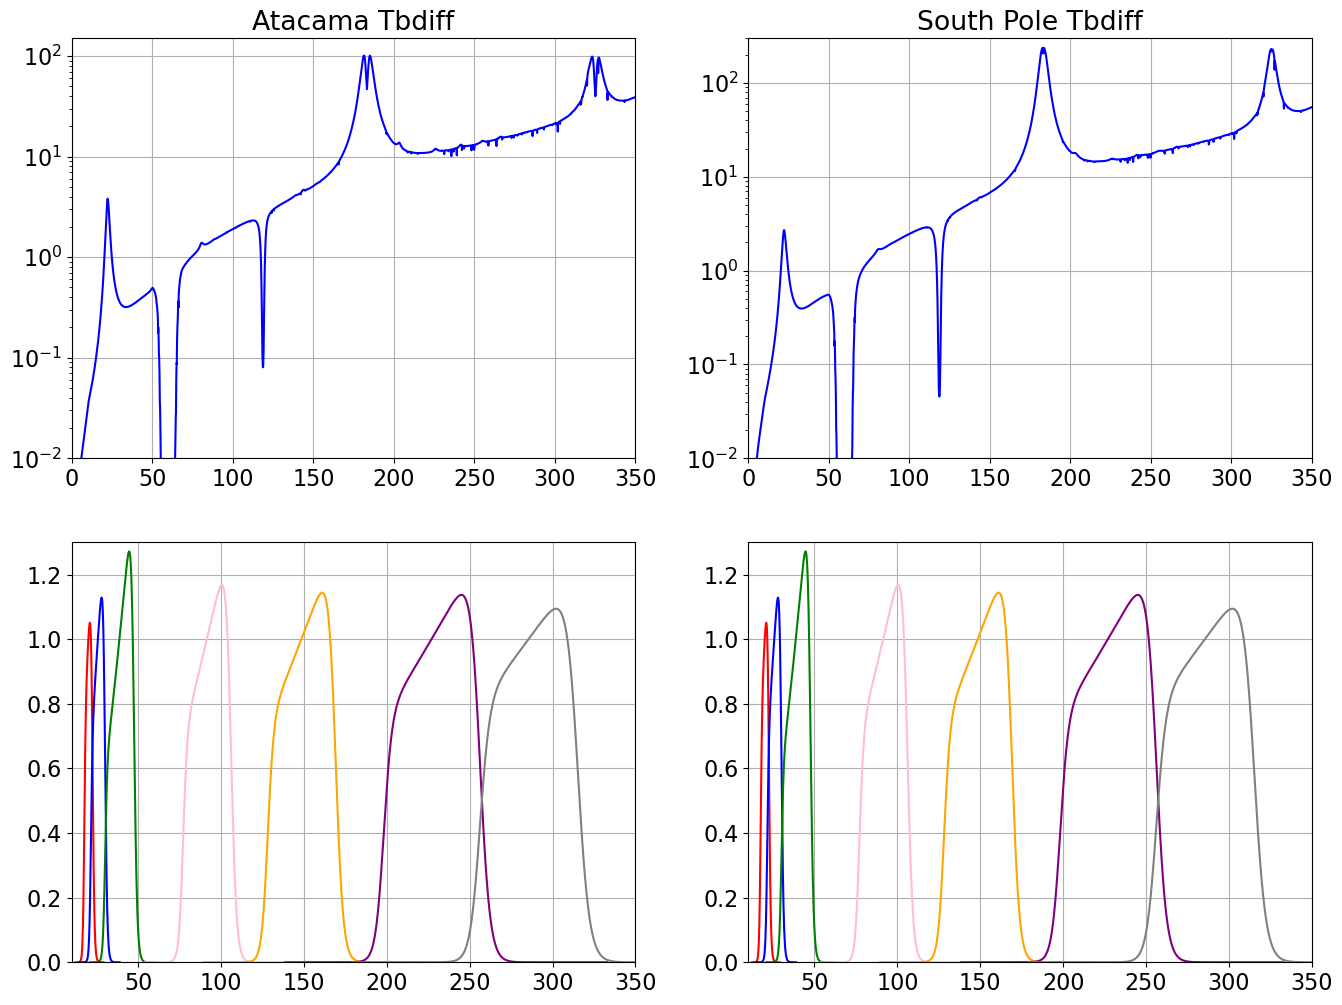

In [45]:
#cut off at 10^-2, two panel plot with top: bands bottom:below, put dot for each band
bandtype_dict= {'ULF':'red', 'LF_1': 'blue', 'LF_2': 'green', 'MF_1': 'pink', 'MF_2': 'orange', 'HF_1': 'purple', 'HF_2': 'grey'}
bandarray=list(bandtype_dict.keys())
#Atacama
plt.subplot(2,2,1)
x=(atmos['Atacama'][900][4]/0.932)+(atmos['Atacama'][1000][4]/0.932)
act_freq=atmos['Atacama'][900][0]
plt.semilogy(act_freq, x/2, color='blue')
plt.ylim(0.01,150)
plt.xlim(0,350)
plt.title('Atacama Tbdiff')
plt.grid()

#South Pole
plt.subplot(2,2,2)
x=(atmos['Pole'][300][4]/0.425)+(atmos['Pole'][400][4]/0.425)
pole_freq=atmos['Pole'][300][0]
plt.semilogy(pole_freq, x/2, color='blue')
plt.ylim(0.01,300)
plt.xlim(0,350)
plt.title('South Pole Tbdiff')
plt.grid()

plt.subplot(2,2,3)
for ch in chlist:   
    btype=bandtype_dict[ch]
    plt.plot(atacama_dict[900][ch]['freqvec'], atacama_dict[900][ch]['bandshape'], color=btype, label='Logistic Band Model')
plt.xlim(10, 350)
plt.ylim(0,1.3)
plt.grid()

plt.subplot(2,2,4)
for ch in chlist:   
    btype=bandtype_dict[ch]
    #plt.axvline(x = x1, color=btype, linestyle='dashed', markersize= 0.5)#, label = 'upper band edge')
    #plt.axvline(x = x2, color=btype, linestyle='dashed', markersize= 0.5)
    #plt.axvspan(x1, x2, alpha=0.2, color=btype) 
    plt.plot(spole_dict[300][ch]['freqvec'], spole_dict[300][ch]['bandshape'], color=btype, label='Logistic Band Model')
plt.xlim(10, 350)
plt.ylim(0,1.3)
plt.grid()

Text(0.5, 1.0, 'Pole: All Bands')

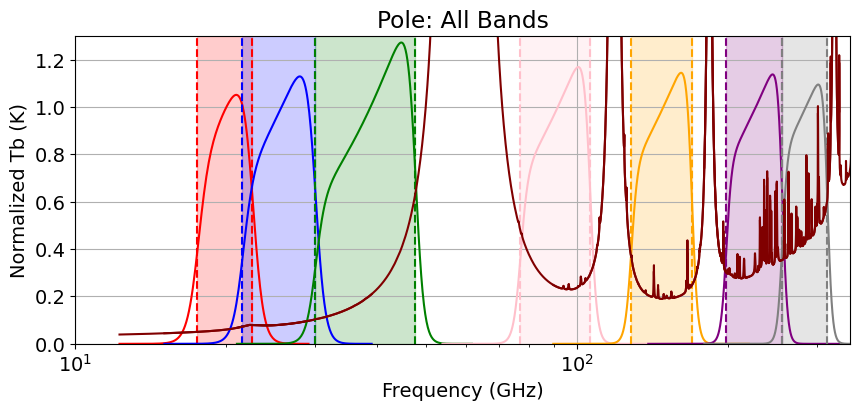

In [46]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [10, 4]

bandtype_dict= {'ULF':'red', 'LF_1': 'blue', 'LF_2': 'green', 'MF_1': 'pink', 'MF_2': 'orange', 'HF_1': 'purple', 'HF_2': 'grey'}
bandarray=list(bandtype_dict.keys())

#for band in bands['SAT'].keys():
    
for ch in chlist:   
    btype=bandtype_dict[ch]
    x1=spole_dict[300][ch]['high_edge_0']
    x2=spole_dict[300][ch]['low_edge_0']
    plt.axvline(x = x1, color=btype, linestyle='dashed', markersize= 0.5)#, label = 'upper band edge')
    plt.axvline(x = x2, color=btype, linestyle='dashed', markersize= 0.5)
        #plt.fill_between(x1, x2, color='blue', alpha=.2)
    plt.axvspan(x1, x2, alpha=0.2, color=btype) 
    
    plt.semilogx(spole_dict[300][ch]['freqvec'], spole_dict[300][ch]['bandshape'], color=btype, label='Logistic Band Model')
    plt.semilogx(spole_dict[300][ch]['freqvec'], spole_dict[300][ch]['tbvec']/50, color='maroon', linestyle='solid', markersize= 0.15)
#note that model 1 includes optics/lyot info and instrumentation info
plt.xlim(10, 350)
plt.ylim(0, 1.3)
plt.grid()
plt.xlabel('Frequency (GHz)')
plt.ylabel('Normalized Tb (K)')
plt.title('Pole: All Bands')

Text(0.5, 1.0, 'Atacama: All Bands')

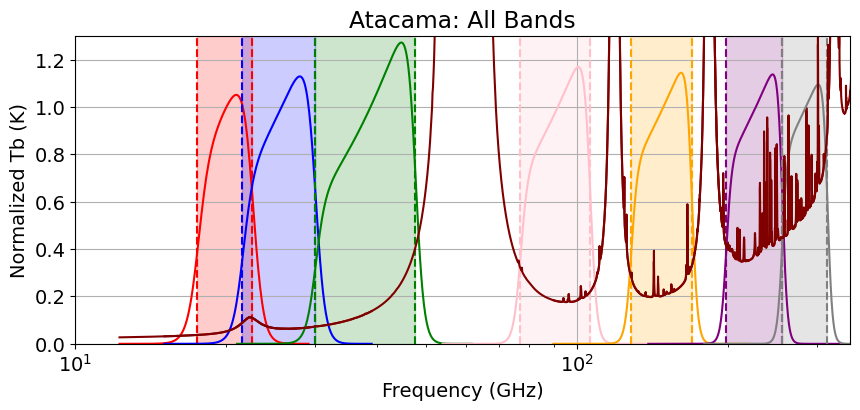

In [47]:
bandtype_dict= {'ULF':'red', 'LF_1': 'blue', 'LF_2': 'green', 'MF_1': 'pink', 'MF_2': 'orange', 'HF_1': 'purple', 'HF_2': 'grey'}
bandarray=list(bandtype_dict.keys())

#for band in bands['SAT'].keys():
    
for ch in chlist:   
    btype=bandtype_dict[ch]
    x1=atacama_dict[900][ch]['high_edge_0']
    x2=atacama_dict[900][ch]['low_edge_0']
    plt.axvline(x = x1, color=btype, linestyle='dashed', markersize= 0.5)#, label = 'upper band edge')
    plt.axvline(x = x2, color=btype, linestyle='dashed', markersize= 0.5)
        #plt.fill_between(x1, x2, color='blue', alpha=.2)
    plt.axvspan(x1, x2, alpha=0.2, color=btype) 
    
    plt.semilogx(atacama_dict[900][ch]['freqvec'], atacama_dict[900][ch]['bandshape'], color=btype, label='Logistic Band Model')
    plt.semilogx(atacama_dict[900][ch]['freqvec'], atacama_dict[900][ch]['tbvec']/50, color='maroon', linestyle='solid', markersize= 0.15)
#note that model 1 includes optics/lyot info and instrumentation info
plt.xlim(10, 350)
plt.ylim(0, 1.3)
plt.grid()
plt.xlabel('Frequency (GHz)')
plt.ylabel('Normalized Tb (K)')
plt.title('Atacama: All Bands')


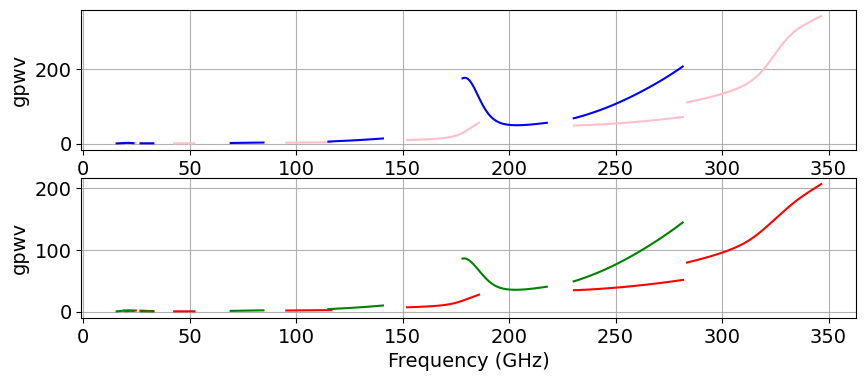

In [48]:
plt.subplot(2,1,1)
for ch in chlist:
    plt.plot(spole_dict[300][ch]['highvec'], spole_dict[300][ch]['gpwv_h'], color='pink')
    plt.plot(spole_dict[300][ch]['lowvec'], spole_dict[300][ch]['gpwv_l'], color='blue')
plt.ylabel('gpwv')
plt.grid()

plt.subplot(2,1,2)
for ch in chlist:
    plt.plot(atacama_dict[900][ch]['highvec'], atacama_dict[900][ch]['gpwv_h'], color='red')
    plt.plot(atacama_dict[900][ch]['lowvec'], atacama_dict[900][ch]['gpwv_l'], color='green')
plt.ylabel('gpwv')
plt.xlabel('Frequency (GHz)')
plt.grid()
    
#plt.legend()

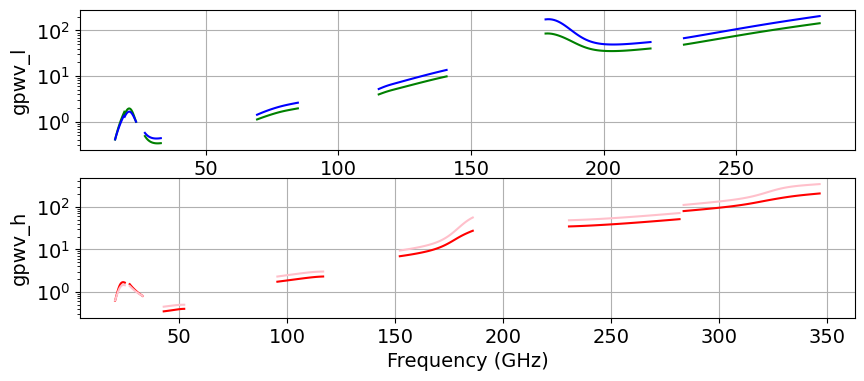

In [49]:
#comparison of the two sites and their respective gpwv high and low values
plt.subplot(2,1,1)
for ch in chlist:
    plt.semilogy(atacama_dict[900][ch]['lowvec'], atacama_dict[900][ch]['gpwv_l'], color='green')
    plt.semilogy(spole_dict[300][ch]['lowvec'], spole_dict[300][ch]['gpwv_l'], color='blue')
plt.ylabel('gpwv_l')
plt.grid()

plt.subplot(2,1,2)
for ch in chlist:
    plt.semilogy(atacama_dict[900][ch]['highvec'], atacama_dict[900][ch]['gpwv_h'], color='red')
    plt.semilogy(spole_dict[300][ch]['highvec'], spole_dict[300][ch]['gpwv_h'], color='pink')
plt.ylabel('gpwv_h')
plt.xlabel('Frequency (GHz)')
plt.grid()
    
#plt.legend()

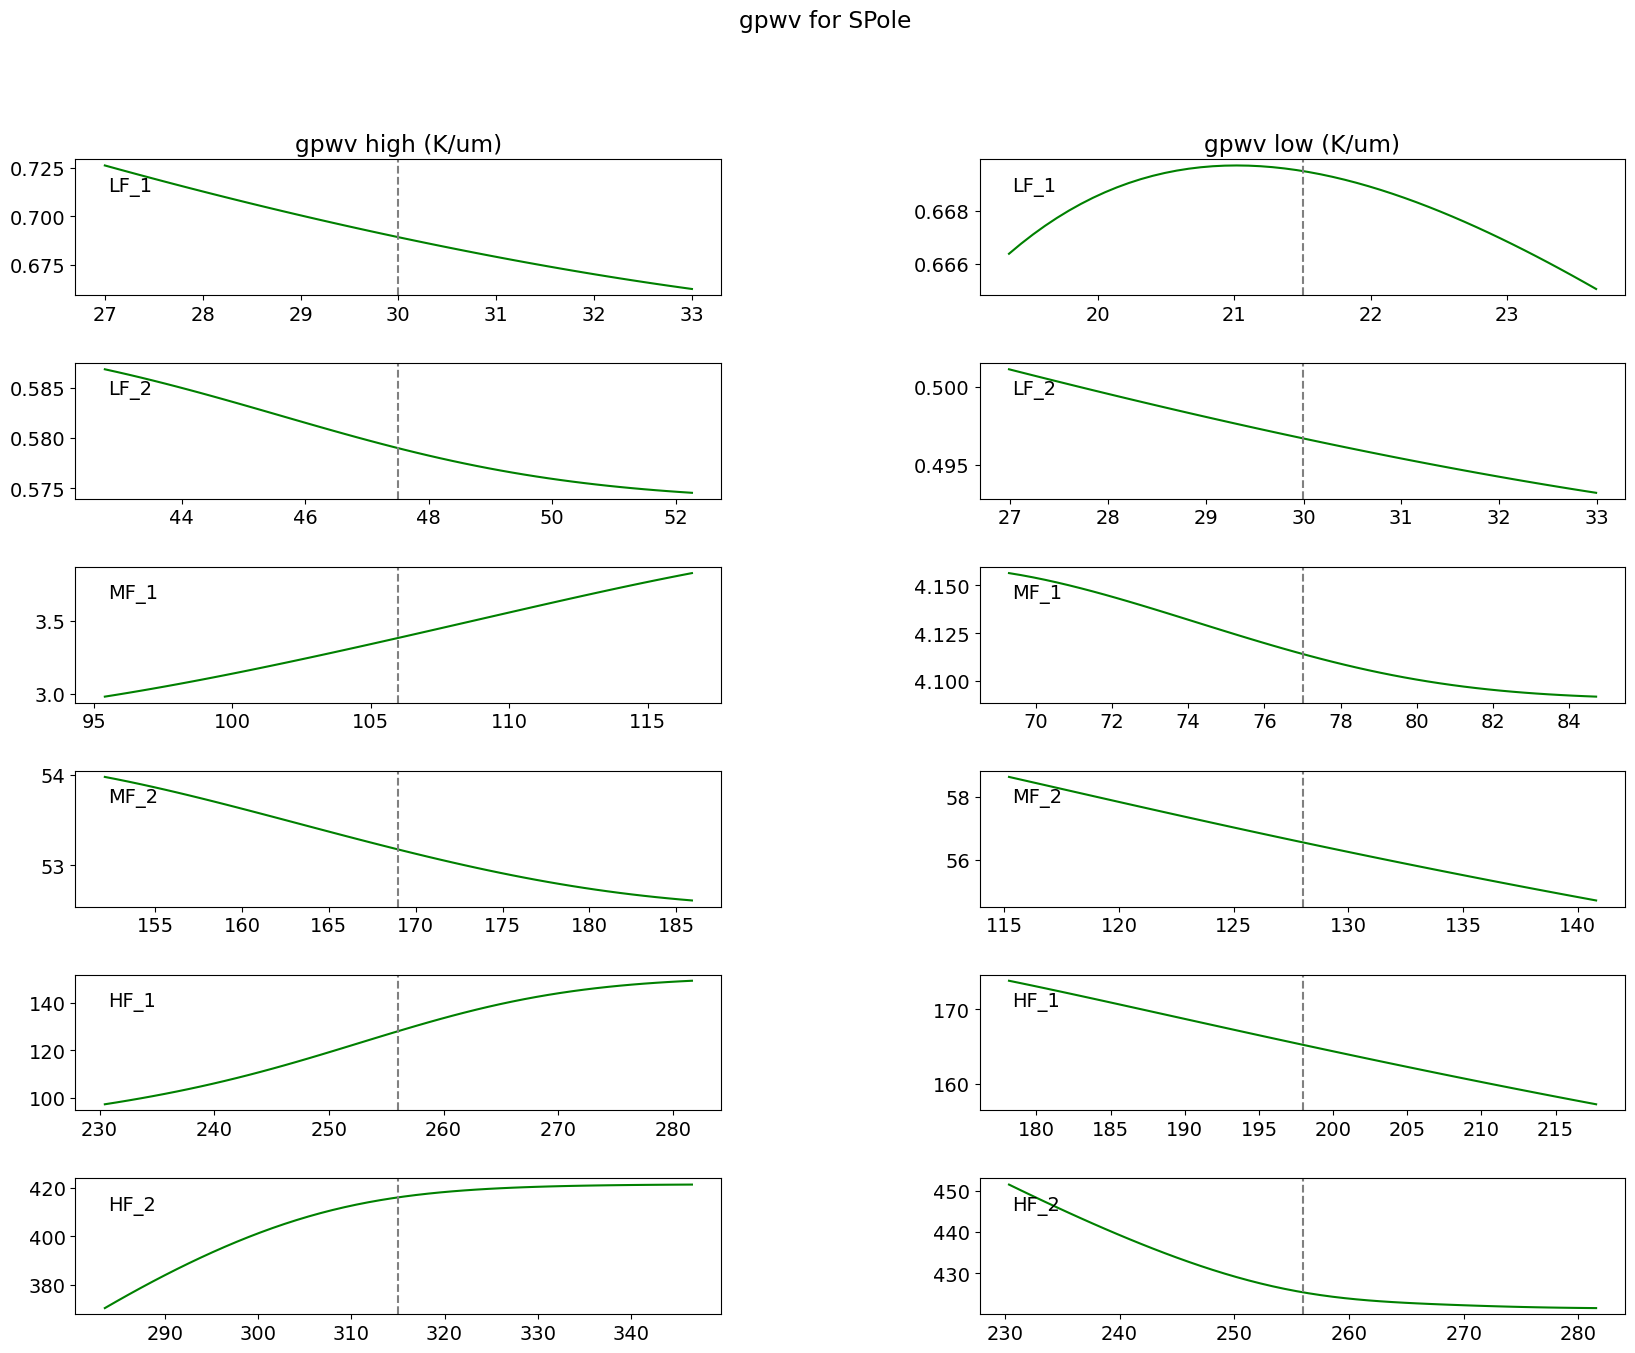

In [40]:
#SPole plots
ii1_dict= {'LF_1':0, 'LF_2':0, 'MF_1':0, 'MF_2':0, 'HF_1':0, 'HF_2':0} #'LF1':0, 'LF2':0, }
ii3_dict= {'LF_1':1, 'LF_2':1, 'MF_1':1, 'MF_2':1, 'HF_1':1, 'HF_2':1}
ii2_dict=  {'LF_1':0, 'LF_2':1, 'MF_1':2, 'MF_2':3, 'HF_1':4, 'HF_2':5} #, 'w188':1, 'w203':2, 'w204': 3, 'w206':4}
bandarray=list(ii1_dict.keys())
pwvtype_dict= {300: 'g', 900: 'r', 2200: 'b'}
figure, axis = plt.subplots(6, 2, figsize=(20,15))

figure.subplots_adjust(hspace=0.5, wspace=0.4)
figure.suptitle('gpwv for SPole')#,fontsize=20)
figure.set_constrained_layout_pads(w_pad=2 / 72, h_pad=2 / 72, hspace=0.1,
                                wspace=0.1)
axis[0,0].set_title('gpwv high (K/um)')
axis[0,1].set_title('gpwv low (K/um)')

#figure.text(0.08, 0.3, 'dt_cmb/dpwv (low)', va='center', rotation='vertical')
#figure.text(0.08, 0.7, 'dt_cmb/dpwv (high)', va='center', rotation='vertical')

Pole_pwvs= [300]
Atacama_pwvs= [900]

for pwv in Pole_pwvs:
    for ch in chlist:
        if ch != 'ULF':
            pwvtype= pwvtype_dict[pwv]
            ii1= ii1_dict[ch]
            ii2= ii2_dict[ch] 
            ii3= ii3_dict[ch] 
            axis[ii2, ii1].plot(spole_dict[pwv][ch]['highvec'], spole_dict[pwv][ch]['gpwv_h'], pwvtype, markersize= 3)
            axis[ii2, ii1].text(0.05, 0.8, ch, horizontalalignment='left',verticalalignment='center', transform=axis[ii2,ii1].transAxes)
            axis[ii2, ii1].axvline(x = spole_dict[pwv][ch]['high_edge_0'], color='grey', linestyle='dashed', label = 'upper band edge')
            axis[ii2, ii3].plot(spole_dict[pwv][ch]['lowvec'], spole_dict[pwv][ch]['gpwv_l'], pwvtype, markersize= 3)
            axis[ii2, ii3].text(0.05, 0.8, ch, horizontalalignment='left',verticalalignment='center', transform=axis[ii2,ii3].transAxes)
            axis[ii2, ii3].axvline(x = spole_dict[pwv][ch]['low_edge_0'], color='grey', linestyle='dashed', label = 'upper band edge')
            #axis[ii3, ii2].set_xlabel('Frequency (GHz)', loc='center')

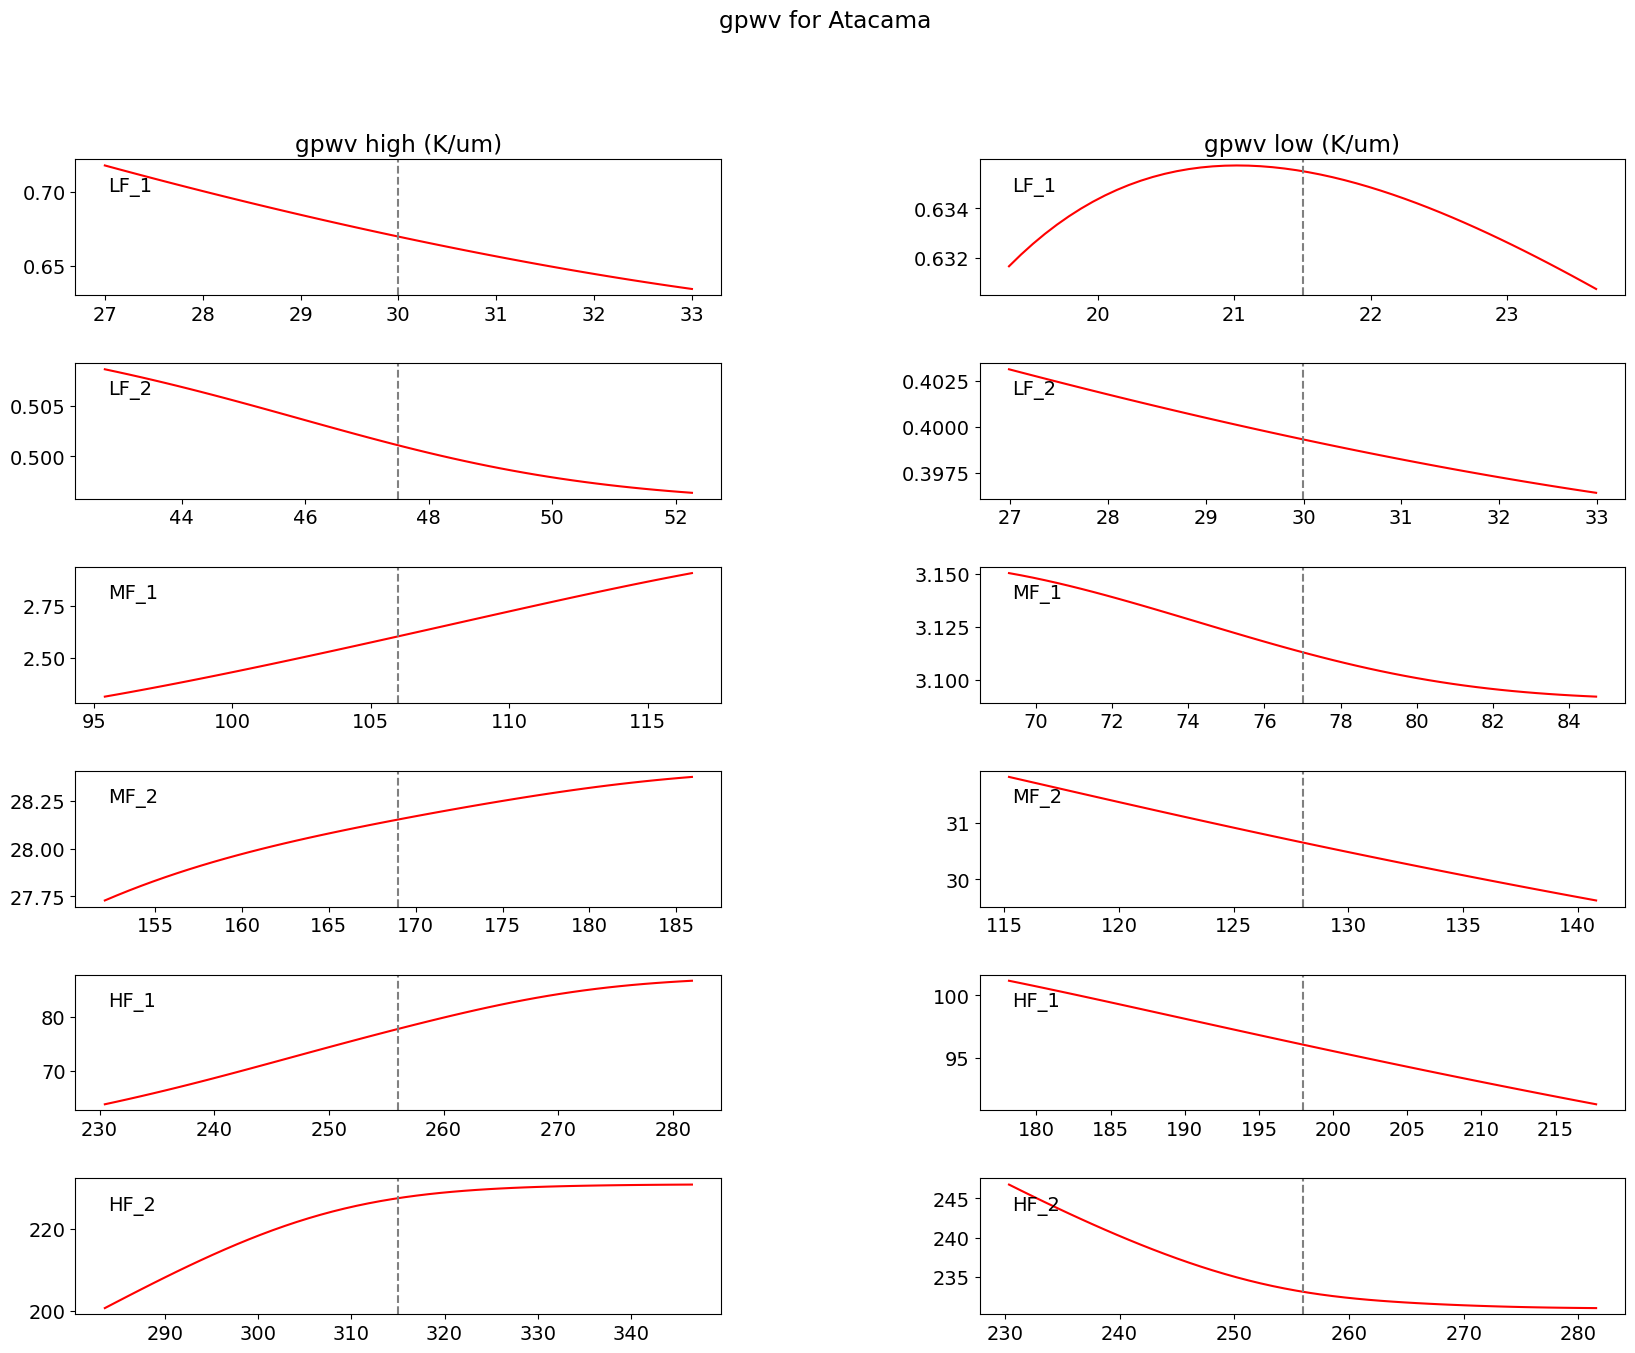

In [41]:
#Atacama plots 
ii1_dict= {'LF_1':0, 'LF_2':0, 'MF_1':0, 'MF_2':0, 'HF_1':0, 'HF_2':0} #'LF1':0, 'LF2':0, }
ii3_dict= {'LF_1':1, 'LF_2':1, 'MF_1':1, 'MF_2':1, 'HF_1':1, 'HF_2':1}
ii2_dict=  {'LF_1':0, 'LF_2':1, 'MF_1':2, 'MF_2':3, 'HF_1':4, 'HF_2':5} #, 'w188':1, 'w203':2, 'w204': 3, 'w206':4}
bandarray=list(ii1_dict.keys())
pwvtype_dict= {400: 'g', 900: 'r', 2200: 'b'}
figure, axis = plt.subplots(6, 2, figsize=(20,15))

figure.subplots_adjust(hspace=0.5, wspace=0.4)
figure.suptitle('gpwv for Atacama')#,fontsize=20)
#figure.text(0.5, 0.08, 'Frequency (GHz)', ha='center')
figure.set_constrained_layout_pads(w_pad=2 / 72, h_pad=2 / 72, hspace=0.1,
                                wspace=0.1)
axis[0,0].set_title('gpwv high (K/um)')
axis[0,1].set_title('gpwv low (K/um)')

#figure.text(0.08, 0.3, 'dt_cmb/dpwv (low)', va='center', rotation='vertical')
#figure.text(0.08, 0.7, 'dt_cmb/dpwv (high)', va='center', rotation='vertical')

Pole_pwvs= [400]
Atacama_pwvs= [900]

for pwv in Atacama_pwvs:
    for ch in chlist:
        if ch != 'ULF':
            pwvtype= pwvtype_dict[pwv]
            ii1= ii1_dict[ch]
            ii2= ii2_dict[ch] 
            ii3= ii3_dict[ch] 
            axis[ii2, ii1].plot(atacama_dict[pwv][ch]['highvec'], atacama_dict[pwv][ch]['gpwv_h'], pwvtype, markersize= 3)
            axis[ii2, ii1].text(0.05, 0.8, ch, horizontalalignment='left',verticalalignment='center', transform=axis[ii2,ii1].transAxes)

            axis[ii2, ii1].axvline(x = atacama_dict[pwv][ch]['high_edge_0'], color='grey', linestyle='dashed', label = 'upper band edge')
            axis[ii2, ii3].plot(atacama_dict[pwv][ch]['lowvec'], atacama_dict[pwv][ch]['gpwv_l'], pwvtype, markersize= 3)
            axis[ii2, ii3].text(0.05, 0.8, ch, horizontalalignment='left',verticalalignment='center', transform=axis[ii2,ii3].transAxes)
            axis[ii2, ii3].axvline(x = atacama_dict[pwv][ch]['low_edge_0'], color='grey', linestyle='dashed', label = 'upper band edge')
            #axis[ii2, ii3].set_xlabel('Frequency (GHz)', loc='center')

### Redoing the Above Plots Differently 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


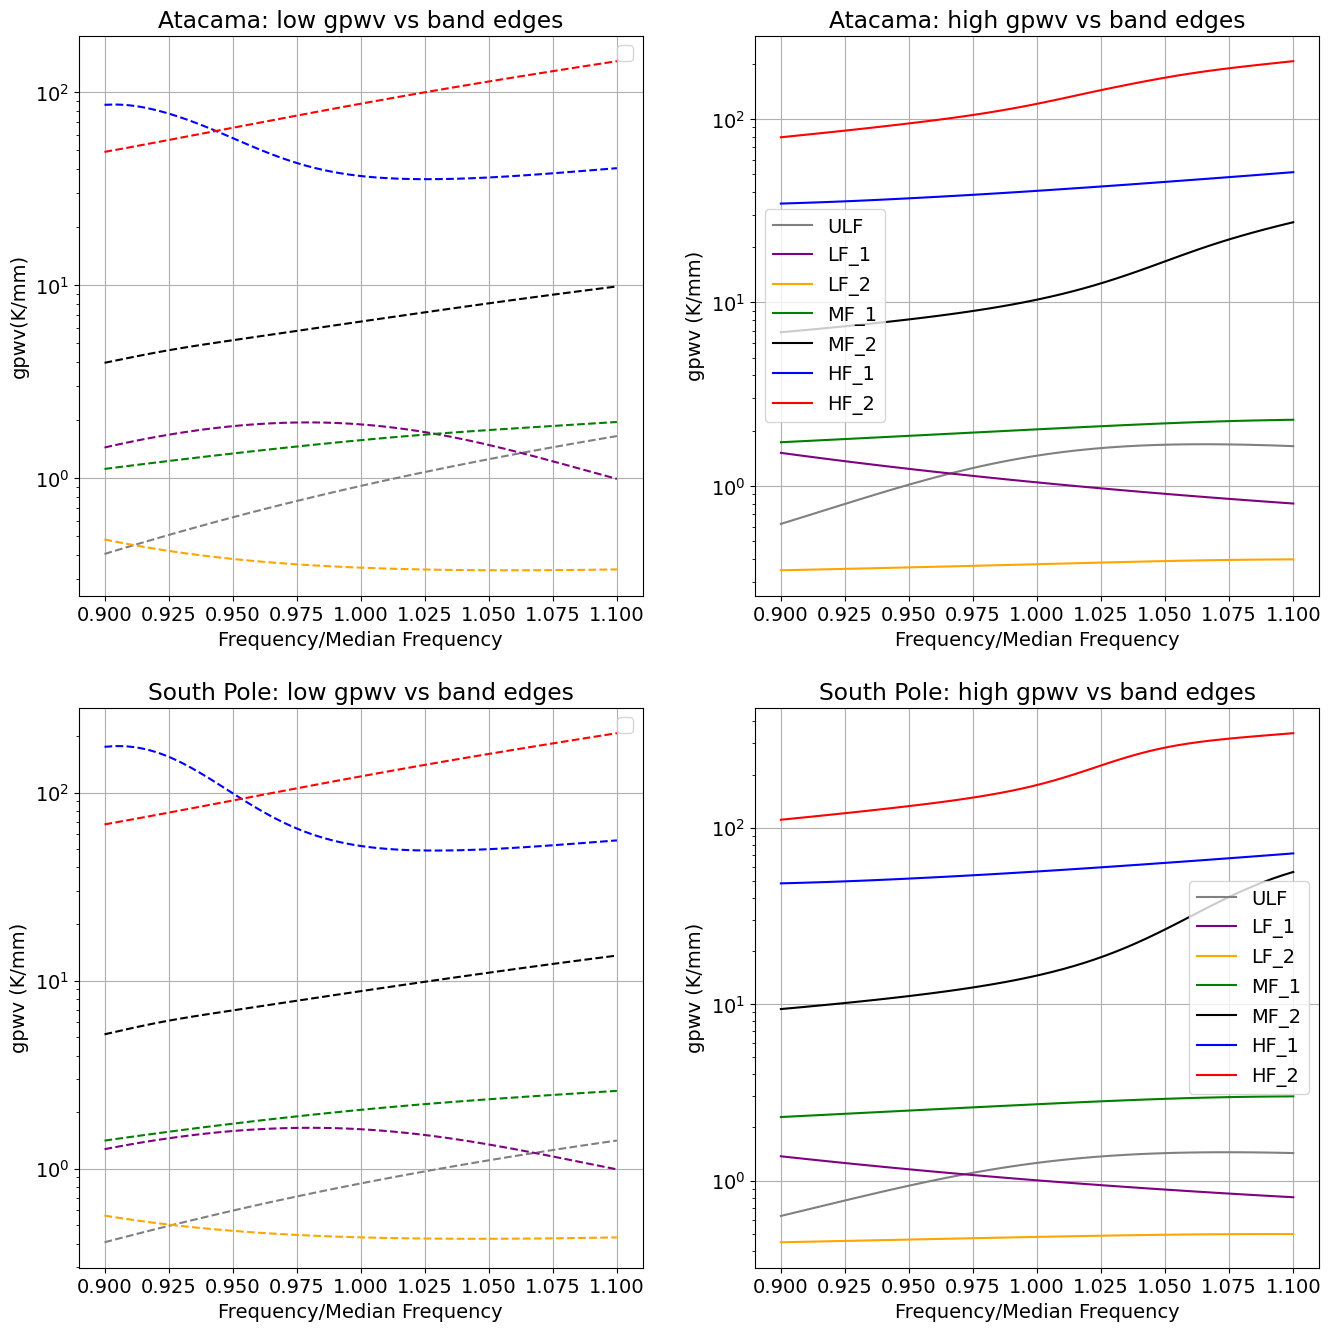

In [50]:
#comparison of the two sites and their respective gpwv high and low values
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [16, 16]

bandtype_dict= {'LAT':{'HF_2':'red', 'HF_1': 'blue', 'MF_2': 'black', 
                       'MF_1': 'green', 'LF_2': 'orange', 'LF_1': 'purple', 'ULF': 'grey'}}
bandarray=list(bandtype_dict.keys())

plt.subplot(2,2,1)
for ch in chlist:
    btype=bandtype_dict['LAT'][ch]
    plt.semilogy(atacama_dict[900][ch]['lowvec']/np.median(atacama_dict[900][ch]['lowvec']), (atacama_dict[900][ch]['gpwv_l']), color=btype, linestyle='dashed')#, label=ch)
plt.ylabel('gpwv(K/mm)')
plt.xlabel('Frequency/Median Frequency')
plt.title('Atacama: low gpwv vs band edges')
plt.grid()
plt.legend()

plt.subplot(2,2,2)
for ch in chlist:
    btype=bandtype_dict['LAT'][ch]
    plt.semilogy(atacama_dict[900][ch]['highvec']/np.median(atacama_dict[900][ch]['highvec']), (atacama_dict[900][ch]['gpwv_h']), color=btype, label=ch)
plt.ylabel('gpwv (K/mm)')
plt.xlabel('Frequency/Median Frequency')
plt.title('Atacama: high gpwv vs band edges')
plt.grid()
plt.legend()

plt.subplot(2,2,3)
for ch in chlist:
    btype=bandtype_dict['LAT'][ch]
    plt.semilogy(spole_dict[300][ch]['lowvec']/np.median(spole_dict[300][ch]['lowvec']), (spole_dict[300][ch]['gpwv_l']), color=btype, linestyle='dashed')
plt.ylabel('gpwv (K/mm)')
plt.xlabel('Frequency/Median Frequency')
plt.title('South Pole: low gpwv vs band edges')
plt.grid()
plt.legend()

plt.subplot(2,2,4)
for ch in chlist:
    btype=bandtype_dict['LAT'][ch]
    plt.semilogy(spole_dict[300][ch]['highvec']/np.median(spole_dict[300][ch]['highvec']), (spole_dict[300][ch]['gpwv_h']), color=btype, label=ch)
plt.ylabel('gpwv (K/mm)')
plt.xlabel('Frequency/Median Frequency')
plt.title('South Pole: high gpwv vs band edges')
plt.grid()
plt.legend()

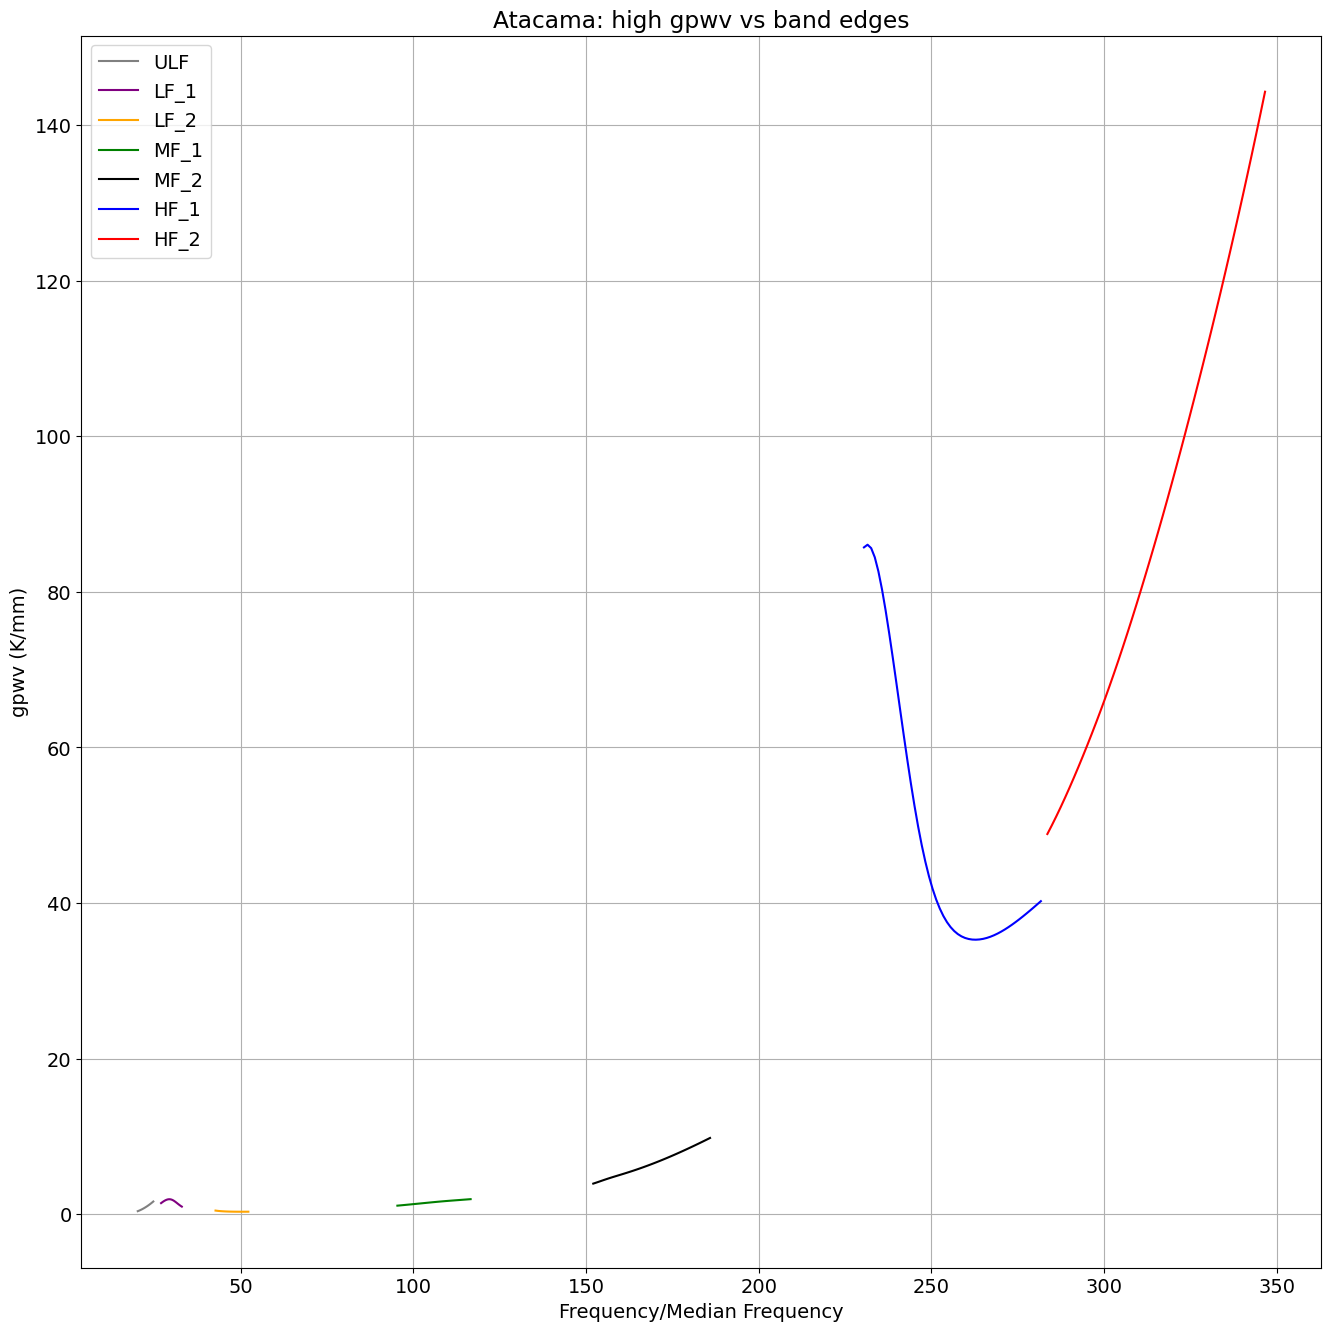

In [51]:
for ch in chlist:
    btype=bandtype_dict['LAT'][ch]
    plt.plot(atacama_dict[900][ch]['highvec'], (atacama_dict[900][ch]['gpwv_l']), color=btype, label=ch)
plt.ylabel('gpwv (K/mm)')
plt.xlabel('Frequency/Median Frequency')
plt.title('Atacama: high gpwv vs band edges')
plt.grid()
plt.legend()

In [52]:
#for ch in chlist:
    #print(atacama_dict[900][ch]['lowvec'])#/np.median(atacama_dict[900][ch]['lowvec']))
    #print((atacama_dict[900][ch]['gpwv_l'])/np.median(atacama_dict[900][ch]['gpwv_l'][25]))
    #plt.plot((atacama_dict[900][ch]['gpwv_l'])/np.median(atacama_dict[900][ch]['gpwv_l'][25]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


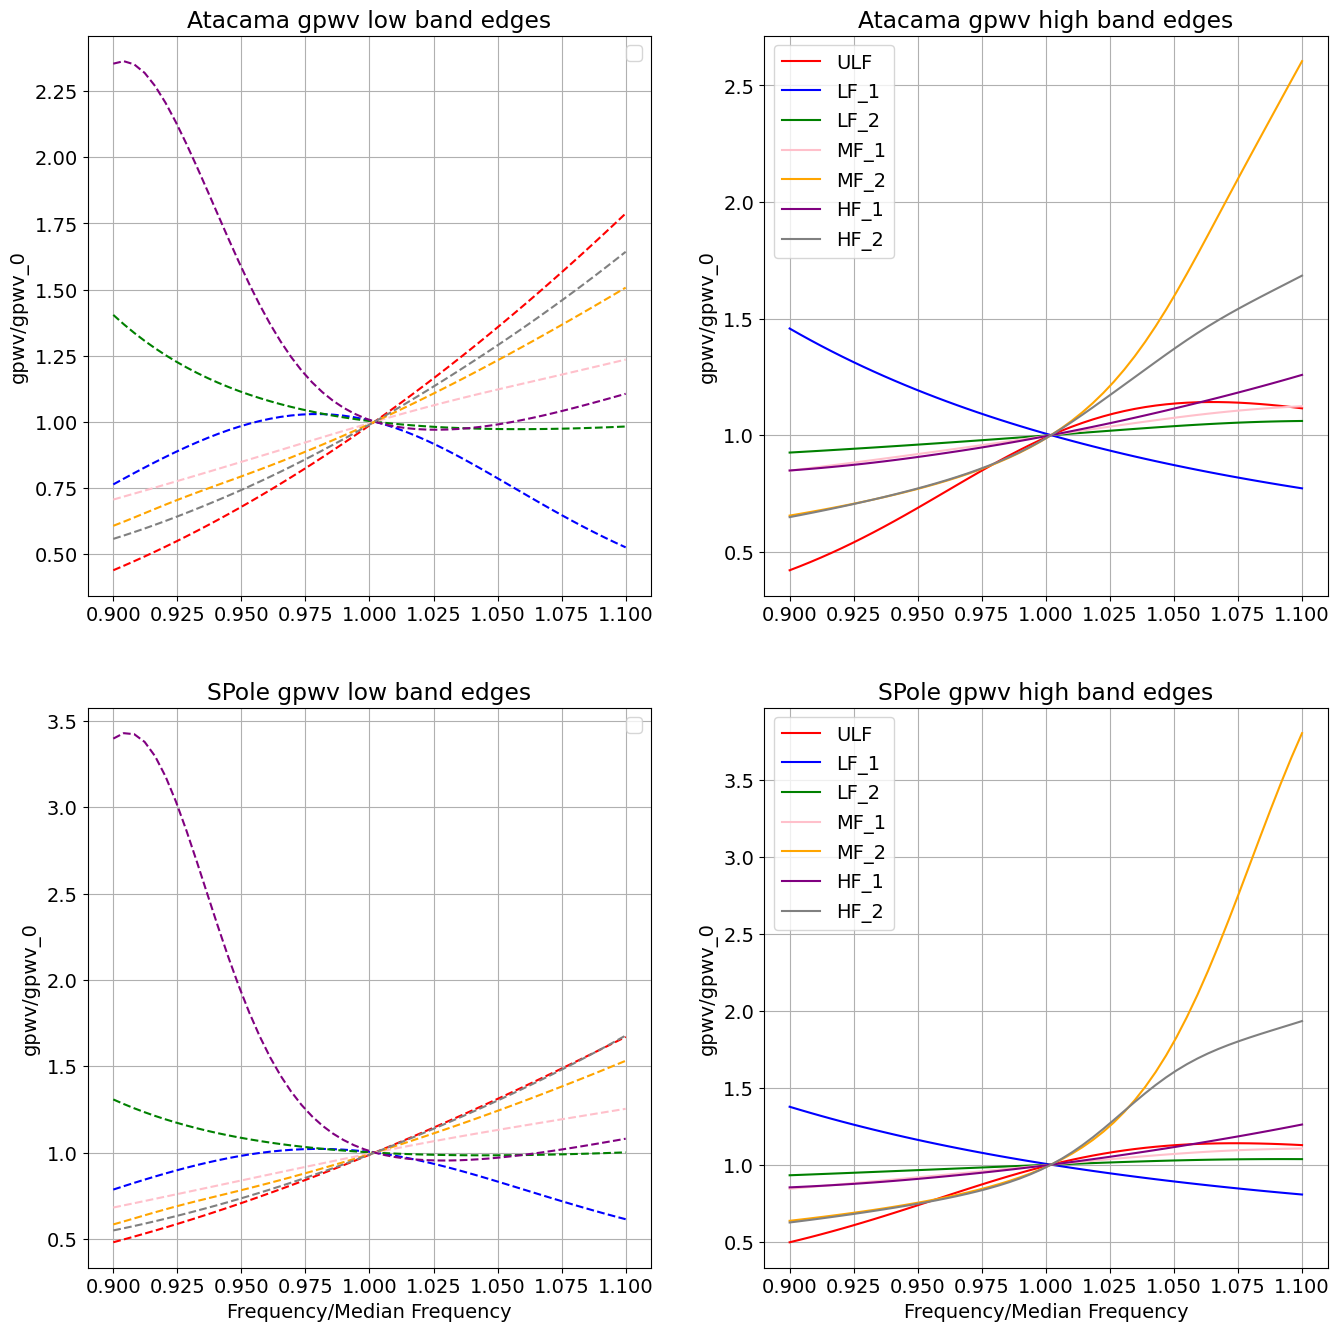

In [53]:
#similar plot but with gpwv high and low values / gpwv center
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [16, 16]

bandtype_dict= {'LAT':{'ULF':'red', 'LF_1': 'blue', 'LF_2': 'green', 
                       'MF_1': 'pink', 'MF_2': 'orange', 'HF_1': 'purple', 'HF_2': 'grey'}}
bandarray=list(bandtype_dict.keys())

#normal=(-np.min())/((np.max()-np.min())
                    
plt.subplot(2,2,1)
for ch in chlist:
    btype=bandtype_dict['LAT'][ch]
    #normal=0.5*(atacama_dict[900][ch]['lowvec']-np.min(atacama_dict[900][ch]['lowvec']))/((np.max(atacama_dict[900][ch]['lowvec'])-np.min(atacama_dict[900][ch]['lowvec'])))+0.75
    #normal2=0.5*((atacama_dict[900][ch]['gpwv_l']-np.min(atacama_dict[900][ch]['gpwv_l']))/((np.max(atacama_dict[900][ch]['gpwv_l']))-np.min(atacama_dict[900][ch]['gpwv_l'])))+0.75
    #plt.plot(normal, normal2, color=btype)#, linestyle='dashed' )
    plt.plot(atacama_dict[900][ch]['lowvec']/np.median(atacama_dict[900][ch]['lowvec']), (atacama_dict[900][ch]['gpwv_l']/np.median(atacama_dict[900][ch]['gpwv_l'][25])), color=btype, linestyle='dashed')#, label=ch)
    #plt.plot(atacama_dict[900][ch]['highvec']/np.median(atacama_dict[900][ch]['highvec']), (atacama_dict[900][ch]['gpwv_h']/np.median(atacama_dict[900][ch]['gpwv_h'])), color=btype, label=ch)
plt.ylabel('gpwv/gpwv_0')
plt.title('Atacama gpwv low band edges')
plt.grid()
plt.legend()

plt.subplot(2,2,2)
for ch in chlist:
    btype=bandtype_dict['LAT'][ch]
    plt.plot(atacama_dict[900][ch]['highvec']/np.median(atacama_dict[900][ch]['highvec']), (atacama_dict[900][ch]['gpwv_h']/np.median(atacama_dict[900][ch]['gpwv_h'][25])), color=btype, label=ch)
plt.ylabel('gpwv/gpwv_0')
plt.title('Atacama gpwv high band edges')
plt.grid()
plt.legend()
    
plt.subplot(2,2,3)
for ch in chlist:
    btype=bandtype_dict['LAT'][ch]
    plt.plot(spole_dict[300][ch]['lowvec']/np.median(spole_dict[300][ch]['lowvec']), spole_dict[300][ch]['gpwv_l']/np.median(spole_dict[300][ch]['gpwv_l'][25]),color=btype, linestyle='dashed')
    #plt.plot(spole_dict[300][ch]['highvec']/np.median(spole_dict[300][ch]['highvec']), spole_dict[300][ch]['gpwv_h']/np.median(spole_dict[300][ch]['gpwv_h']), color=btype, label=ch)
    #plt.plot(spole_dict[300][ch]['lowvec']/np.median(spole_dict[300][ch]['lowvec']), (spole_dict[300][ch]['gpwv_l']/spole_dict[300][ch]['gpwv']), color=btype, linestyle='dashed')
    #plt.plot(spole_dict[300][ch]['highvec']/np.median(spole_dict[300][ch]['highvec']), (spole_dict[300][ch]['gpwv_h']/spole_dict[300][ch]['gpwv']), color=btype, label=ch)
plt.ylabel('gpwv/gpwv_0')
plt.title('SPole gpwv low band edges')
plt.xlabel('Frequency/Median Frequency')
plt.grid()
plt.legend()

plt.subplot(2,2,4)
for ch in chlist:
    btype=bandtype_dict['LAT'][ch]
    #plt.plot(spole_dict[300][ch]['lowvec']/np.median(spole_dict[300][ch]['lowvec']), spole_dict[300][ch]['gpwv_l']/np.median(spole_dict[300][ch]['gpwv_l']),color=btype, linestyle='dashed')
    plt.plot(spole_dict[300][ch]['highvec']/np.median(spole_dict[300][ch]['highvec']), spole_dict[300][ch]['gpwv_h']/np.median(spole_dict[300][ch]['gpwv_h'][25]), color=btype, label=ch)
plt.ylabel('gpwv/gpwv_0')
plt.title('SPole gpwv high band edges')
plt.xlabel('Frequency/Median Frequency')
plt.grid()
plt.legend()


# Creating a Chart with gpwv values 

We want to make sure they are consistent with previous values

In [56]:
print('SPole LAT New Band Edges @ +/-30% dTcmb/dpwv values')
print('band   pwv    nom_high  new_high  high_%  nom_low  new_low   low_%')
#figure.subplots_adjust(hspace=0.2, wspace=0.4)
#figure.suptitle('Pole')#,fontsize=20)

Pole_pwvs= [300] #[200,400, 600]
#for Pole in sites:
for pwv in Pole_pwvs:
    for ch in chlist:
        f_high= spole_dict[pwv][ch]['highvec'] #
        y_high= spole_dict[pwv][ch]['gpwv_h'] #
        f0_high = spole_dict[pwv][ch]['high_edge_0'] # nominal band edge
        #repeat for the lower edges
        f_low= spole_dict[pwv][ch]['lowvec'] #
        y_low= spole_dict[pwv][ch]['gpwv_l'] #
        f0_low = spole_dict[pwv][ch]['low_edge_0'] # nominal band edge
                #
        jj_high = np.argmin((f_high - f0_high)**2)
        jj_low = np.argmin((f_low - f0_low)**2)
        y0_high = y_high[jj_high]
        y0_low = y_low[jj_low]
                #
        yval_high = 1.3*y0_high # 30% higher than nominal
        yval_low = 0.7*y0_high  # 30% lower than nominal
        zz_high = (y_high-yval_high)**2
        zz_low = (y_low-yval_low)**2
        
        ii_high = np.argmin(zz_high)
        ii_low = np.argmin(zz_low)

        high_ghz_percent = f_high[ii_high]/f0_high 
        low_ghz_percent = f_low[ii_low]/f0_low
        rowname1 = ch
        print(rowname1.ljust(5),end='')
        print('{0:7.2f}  {1:7.2f}  {2:7.2f}  {3:7.4f}  {4:7.2f}  {5:7.2f}  {6:7.4f}'.format(pwv, f0_high, f_high[ii_high], high_ghz_percent, f0_low, f_low[ii_low], low_ghz_percent))

SPole LAT New Band Edges @ +/-30% dTcmb/dpwv values
band   pwv    nom_high  new_high  high_%  nom_low  new_low   low_%
ULF   300.00    22.50    24.20   1.0755    17.50    17.61   1.0061
LF_1  300.00    30.00    27.37   0.9122    21.50    23.65   1.1000
LF_2  300.00    47.51    51.87   1.0918    29.99    31.40   1.0469
MF_1  300.00   106.00   116.60   1.1000    77.00    74.96   0.9735
MF_2  300.00   169.00   173.48   1.0265   128.00   131.40   1.0265
HF_1  300.00   256.06   281.67   1.1000   197.94   204.00   1.0306
HF_2  300.00   315.05   322.12   1.0224   255.95   255.43   0.9980
